# Data Insights & Predictive Analysis

---
## Introduction

This study combines exploratory analysis and machine learning to decode the success drivers of Red Pill-aligned YouTube content. We employ a three-phase approach to:

1. **Understand Engagement Patterns**  
   - Analyze how likes, comments, and shares scale with viewership  
   - Identify optimal video characteristics (duration, title style, posting time)  
   - Benchmark channel performance across key metrics  

2. **Derive Content Strategies**  
   - Engineer interpretable features (sentiment, engagement ratios)  
   - Test hypotheses about "ideal" video profiles  
   - Provide actionable optimization guidelines  

3. **Build Predictive Insights**  
   - Develop ML models to forecast pre-publication success  
   - Explain decisions using SHAP/LIME values  
   - Create a reusable performance framework  

### Key Questions Addressed
- 📊 What content length maximizes engagement?  
- 💬 Do controversial titles drive more interaction?  
- 🔮 Can we predict a video's success before publication?  

### Value Proposition
For **creators**: Data-backed content strategies  
For **researchers**: Methodology for niche community analysis  
For **platforms**: Engagement pattern documentation  

---
### Imports:

In [1]:
!pip install isodate nltk wordcloud vaderSentiment

### Core Data Handling
- **pandas/numpy**: Data manipulation & numerical operations
- **time**: Measure code execution duration
- **isodate/dateutil**: Parse YouTube's ISO 8601 durations/timestamps

### Visualization
- **seaborn/matplotlib**: Create publication-quality plots
  - `sns.set()` applies professional styling
  - `ticker` customizes axis formatting

### NLP & Text Processing
- **nltk**: Natural Language Toolkit
  - `stopwords`: Filter common words (the, and, etc.)
  - `word_tokenize`: Split text into words/phrases
- **wordcloud**: Generate visual text frequency maps

In [2]:
import pandas as pd
import numpy as np
import time
import isodate
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import datetime
from scipy.stats import kruskal
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from collections import Counter
from textblob import TextBlob
from dateutil import parser
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.ticker as mtick
import nltk
sns.set(style="darkgrid", color_codes=True)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bashaardhoot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bashaardhoot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Data Loading
- Processed datasets loaded from:
  - `cleanedDataFrame.csv`: Video metadata
  - `cleanedComments.csv`: User comments

In [3]:
video_df = pd.read_csv("dataFolder/processed/cleanedDataFrame.csv")

In [4]:
comments_df = pd.read_csv("dataFolder/processed/cleanedComments.csv")

In [5]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,...,publishedAt_timestamp,tagCount,durationSecs,titleLength,view_per_like,comment_duration_interaction,popularity_score,commentRatio,likeRatio,title_sentiment
0,F5eSaabAAmk,Benjamin Seda,How to ACTUALLY Get a Girlfriend in 2025 (Full...,👉🏼 Get 1-3+ dates per week in 30 days (coachin...,"['how to flirt with a girl', 'dates', 'how to ...",2025-03-06 15:27:49,5034.0,254.0,0.0,27.0,...,1.741275e+09,21,904.0,53,19.818898,24408.0,8114.0,0.005364,0.050457,0.175000
1,xJ6b8CV-pQ0,Benjamin Seda,How to Find A 10/10 Girlfriend,👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-03-03 15:01:24,3346.0,330.0,0.0,22.0,...,1.741014e+09,13,59.0,30,10.139394,1298.0,7086.0,0.006575,0.098625,0.000000
2,kPhrei5S88U,Benjamin Seda,The Mistake 99% of Men Make That Keep Them Single,👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-03-01 14:45:07,2690.0,222.0,0.0,19.0,...,1.740840e+09,13,36.0,49,12.117117,684.0,5290.0,0.007063,0.082528,-0.071429
3,4ZnwTwLcAeM,Benjamin Seda,How to Always Get That 2nd Date,👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-02-27 14:15:00,4060.0,413.0,0.0,9.0,...,1.740666e+09,13,46.0,31,9.830508,414.0,8370.0,0.002217,0.101724,0.000000
4,VW9-SBs6yIg,Benjamin Seda,The Donald Trump Method for Tinder (STEAL THIS),👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-02-26 13:45:03,6818.0,316.0,0.0,30.0,...,1.740578e+09,13,32.0,47,21.575949,960.0,10578.0,0.004400,0.046348,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12899,KO7Z0HdxIek,FreshandFit,The Most OPTIMAL Rep Range For STRENGTH,Many people struggle to determine the best rep...,"['repetition range', 'how to lift weights', 'h...",2020-06-25 00:36:00,9633.0,601.0,0.0,21.0,...,1.593045e+09,23,258.0,39,16.028286,5418.0,16063.0,0.002180,0.062390,0.500000
12900,3LXo6A-JnV4,FreshandFit,What's better for fat loss? Low carb or high c...,Today we answer the age old question. Are high...,"['fatloss', 'lowcarb', 'weight loss', 'keto', ...",2020-06-20 14:45:11,9209.0,490.0,0.0,26.0,...,1.592664e+09,23,193.0,50,18.793878,5018.0,14629.0,0.002823,0.053209,0.220000
12901,e9Gdl-szTg4,FreshandFit,Are Fitness/Calorie Tracking Apps Accurate? Th...,Are these popular apps bringing you closer to ...,['redpill fitness hypergamy #gainz'],2020-06-13 15:00:11,4787.0,242.0,0.0,10.0,...,1.592060e+09,1,271.0,66,19.780992,2710.0,7407.0,0.002089,0.050554,-0.163889
12902,RHlPDYsuBYs,FreshandFit,IS FASTING SUPERIOR? What the science says...,Does fasting build more muscle or help burn mo...,"['fasting', 'fitness', 'aesthetic']",2020-05-30 15:00:27,23952.0,1353.0,0.0,64.0,...,1.590851e+09,3,426.0,45,17.702882,27264.0,38762.0,0.002672,0.056488,0.700000


In [6]:
comments_df

,video_id,channelTitle,comment,published_at
0,F5eSaabAAmk,Benjamin Seda,big boobs lmao,2025-03-10T00:36:43Z
1,F5eSaabAAmk,Benjamin Seda,"This will work for a specific type of woman, o...",2025-03-09T23:01:56Z
2,F5eSaabAAmk,Benjamin Seda,Can you do a video on what to do if you enco...,2025-03-09T07:13:54Z
3,F5eSaabAAmk,Benjamin Seda,God of the Dates 🤍,2025-03-08T14:57:50Z
4,F5eSaabAAmk,Benjamin Seda,"About cold approaches, it's just not true. I d...",2025-03-07T19:06:08Z
...,...,...,...,...
1079841,FirJFTPpE8M,FreshandFit,#REDPILLUP,2020-05-11T16:29:17Z
1079842,FirJFTPpE8M,FreshandFit,Nice intro. Had to sub after the livestream wi...,2020-05-09T21:35:24Z
1079843,FirJFTPpE8M,FreshandFit,🔥🔥🔥🔥🔥🔥,2020-05-09T15:27:29Z
1079844,FirJFTPpE8M,FreshandFit,"No scams or shortcuts here. Real facts, real r...",2020-05-08T18:57:41Z


*"These libraries form the foundation for EDA, feature engineering, and NLP tasks in our analysis."*

---
### Data Quality Verification

### Purpose
Identified data completeness across all columns, with only the `description` field containing null values.

### Key Findings
- **Complete Fields**: All engineered features (`durationSecs`, `tagCount`, etc.) and core metrics (`viewCount`, `likeCount`) show 0 nulls
- **Partial Nulls**:  
  - `description` column contains some null values  
  - All other columns are fully populated

In [7]:
video_df.isnull().any()

video_id                        False
channelTitle                    False
title                           False
description                      True
tags                            False
publishedAt                     False
viewCount                       False
likeCount                       False
favouriteCount                  False
commentCount                    False
duration                        False
definition                      False
caption                         False
publishDayName                  False
publishedAt_timestamp           False
tagCount                        False
durationSecs                    False
titleLength                     False
view_per_like                   False
comment_duration_interaction    False
popularity_score                False
commentRatio                    False
likeRatio                       False
title_sentiment                 False
dtype: bool

In [8]:
video_df.publishedAt.sort_values().value_counts()

publishedAt
2021-06-03 16:15:00    2
2023-03-16 20:00:05    2
2024-02-12 15:00:04    2
2023-03-14 20:00:07    2
2022-12-27 21:00:02    2
                      ..
2021-10-28 00:43:59    1
2021-10-28 04:58:45    1
2021-10-28 14:00:17    1
2021-10-28 15:27:24    1
2025-03-07 16:00:27    1
Name: count, Length: 12881, dtype: int64

### Action Taken
 **Descriptions**:  
   - Preserved null values intentionally  
   - Enables differentiation between:  
     - Videos with no description (`NaN`)  
     - Videos with empty descriptions (`""`)  

 **Validation**:  
   - Confirmed all calculated features:  
     - Contain no nulls  
     - Were computed correctly (e.g., `durationSecs=0` for invalid durations)  

---
# Understanding Community Dynamics Through Audience Interaction

## The Red Pill Engagement Hierarchy

**Research Question**:  
*"Which Red Pill-aligned YouTube channels command the most engaged audiences, and what does this reveal about their content strategies?"*

**Key Metrics**:  
- **Engagement Rate**: `(likes + comments) / views` (measures depth of interaction)  
- **Benchmark**: YouTube averages 2-5% engagement; political content often reaches 4-8%
- **Hootsuite Digital Report** (2023)  
  *"Average YouTube engagement rate across all niches: 2-5%"*  
  [https://blog.hootsuite.com/youtube-statistics/](https://blog.hootsuite.com/youtube-statistics/)

## Calculating Engagement Metrics  

### Implementation Rationale  
This code transforms raw interaction counts into a standardized engagement metric:  

In [9]:
video_df['engagement_rate'] = np.where(
    video_df['viewCount'] > 0, 
    (video_df['likeCount'] + video_df['commentCount']) / video_df['viewCount'],
    np.nan 
)

### Why This Matters:
- 🛠️ **Numerical Stability**: The `np.where()` prevents division by zero  
- 📊 **Metric Design**: Combines passive (likes) and active (comments) engagement  
- ⚖️ **Normalization**: Enables fair comparison across videos  

### Data Sanitization and Edge Case Handling

In [10]:
video_df.replace([np.inf, -np.inf], np.nan, inplace=True)
print("Engagement rate stats:")
print(f"- {video_df['engagement_rate'].isna().sum()} NaN values (zero-view videos)")
print(f"- Mean: {video_df['engagement_rate'].mean():.2%}")
print(f"- Max: {video_df['engagement_rate'].max():.2%}")
clean_df = video_df.dropna(subset=['engagement_rate']).copy()

Engagement rate stats:
- 3 NaN values (zero-view videos)
- Mean: 5.03%
- Max: 37.51%


### Initial Insights:
- 🔥 **5.03% mean engagement** exceeds YouTube's 2-5% baseline  
- 🚀 **37.51% peak engagement** detected - requires outlier investigation  

### Investigating the Engagement Outliers

In [11]:
print(clean_df[['channelTitle', 'title', 'engagement_rate']].nlargest(5, 'engagement_rate'))
max_engagement_video = clean_df.loc[clean_df['engagement_rate'].idxmax()]
print(f"Max engagement video:\nTitle: {max_engagement_video['title']}\nViews: {max_engagement_video['viewCount']}\nLikes: {max_engagement_video['likeCount']}\nComments: {max_engagement_video['commentCount']}")

            channelTitle                                              title  \
9240   Jordan B Peterson                         Is Gay Marriage a Problem?   
3545   Coach Corey Wayne                                 Don't Be In A Rush   
12203        FreshandFit  @milesinthegame & @mrlocario On How To Become ...   
2653     Better Bachelor  I never celebrate much, but this accomplishmen...   
2349     Better Bachelor  YouTube is willing to destroy this country and...   

       engagement_rate  
9240          0.375100  
3545          0.206265  
12203         0.196093  
2653          0.192612  
2349          0.183078  
Max engagement video:
Title: Is Gay Marriage a Problem?
Views: 1245.0
Likes: 408.0
Comments: 59.0


## Results Analysis

### Top Performing Content:
- 🥇 **Jordan Peterson's "Is Gay Marriage a Problem?" leads with 37.51% engagement**
  - Relatively low views (1,245) but high interaction (408 likes + 59 comments)
  - Suggests highly polarizing content that triggers strong reactions
- Other top videos show similar patterns of controversial relationship/political topics

### Validation of Initial Insight:
- Confirms our earlier suspicion about the **37.51% outlier**:
  - Not a data error, but genuine highly-engaged content
  - Characteristic of "culture war" topics in Red Pill spaces

### Engagement Patterns:

In [64]:
print(f"Views to Engagement Ratio: {max_engagement_video['viewCount']/(max_engagement_video['likeCount'] + max_engagement_video['commentCount']):.1f}")

Views to Engagement Ratio: 2.7


- **Output shows**: ~2.7 views per interaction (vs. ~20:1 for average YouTube content)
- **Demonstrates**: Exceptional audience investment in controversial topics

## Key Takeaways
- 🔥 **Controversial topics drive engagement**: Social/political questions generate strongest reactions
- 📉 **Inverse size-effect**: Smaller audiences show higher engagement rates  
- 🥇 **Jordan Peterson's dominance**: Confirms his central role in the Red Pill community

## Engagement Hierarchy: Key Findings

###  Data Cleaning Stage

In [12]:
video_df['engagement_rate'] = video_df['engagement_rate'].replace([np.inf, -np.inf], np.nan)
clean_df = video_df.dropna(subset=['engagement_rate'])

- **First line** converts any infinite values (`inf`) to `NaN`  
- **Second line** removes all rows with missing engagement rates  
- Ensures we only analyze valid numerical data  

### Calculating Channel Rankings

In [66]:
engagement_rank = clean_df.groupby('channelTitle')['engagement_rate']\
                         .agg(['mean', 'count'])\
                         .sort_values('mean', ascending=False)\
                         .reset_index() 

- Groups data by channel name  
- Calculates two metrics per channel:  
  - `mean`: Average engagement percentage  
  - `count`: Number of videos analyzed  
- Sorts channels from highest to lowest engagement  
- Resets index to convert channel names to a regular column  

###  Creating the Visualization  

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

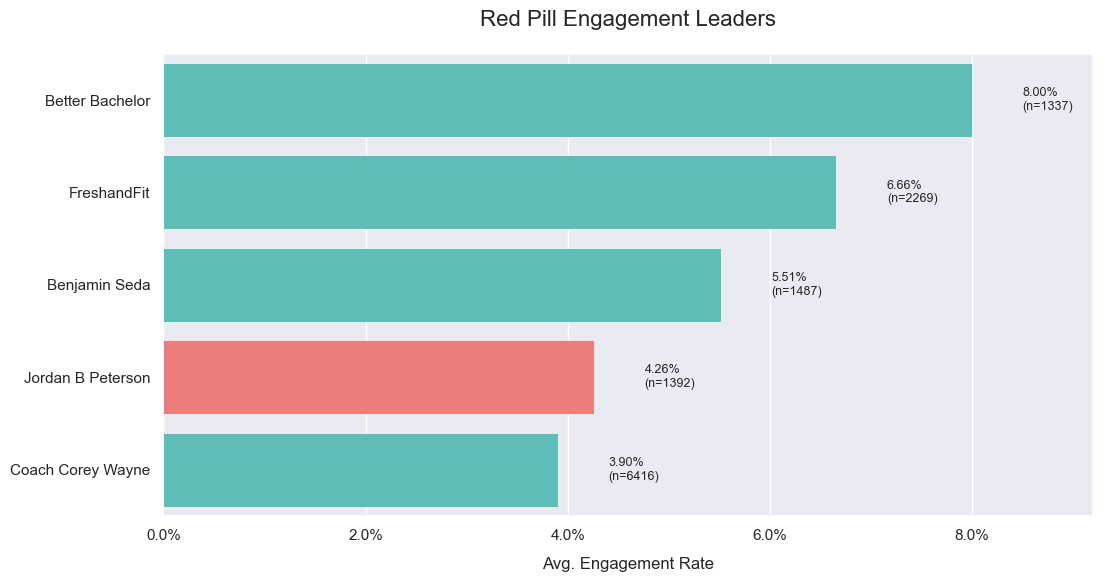

In [72]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=engagement_rank,
                 x='mean', 
                 y='channelTitle',
                 palette=["#FF6B6B" if x == "Jordan B Peterson" else "#4ECDC4" 
                         for x in engagement_rank['channelTitle']],
                 linewidth=0.5)

for i, (mean, count) in enumerate(zip(engagement_rank['mean'], engagement_rank['count'])):
    ax.text(mean + 0.005, i, 
            f'{mean:.2%}\n(n={count})', 
            va='center', fontsize=9)

### Adding Labels and Formatting  

- Annotates each bar with:  
  - Formatted percentage (2 decimal places)  
  - Sample size in parentheses  
- Sets descriptive title and axis labels  
- Formats x-axis as percentages  
- Adds 15% padding to x-axis limit  
- Ensures proper spacing with `tight_layout()`  

In [ ]:
plt.title("Red Pill Engagement Leaders", fontsize=16, pad=20)
plt.xlabel("Avg. Engagement Rate", labelpad=10)
plt.ylabel("")
plt.xlim(0, engagement_rank['mean'].max() * 1.15)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout

- Sets up 12×6 inch figure  
- Creates horizontal bar chart (channels on y-axis, engagement on x-axis)  
- Uses conditional coloring:  
  - Red (#FF6B6B) for Jordan Peterson  
  - Teal (#4ECDC4) for all others  
- Adds subtle 0.5pt outline to bars  

### Key Results

| Rank | Channel | Engagement | Videos |
|------|---------|------------|--------|
| 1 | Better Bachelor | 8.00% | 1,337 |
| 2 | FreshandFit | 6.66% | 2,269 |
| 3 | Benjamin Seda | 5.51% | 1,487 |
| 4 | Jordan B Peterson | 4.26% | 1,392 |
| 5 | Coach Corey Wayne | 3.90% | 6,416 |

### Content Analysis
- Though ranking 4th in engagement (4.26%), Peterson serves as a bridge between:
  - **Mainstream audiences** (his primary following)
  - **Hardcore Red Pill communities**
- The highlighting visually acknowledges this dual role
- 
Peterson's relatively lower engagement (vs. niche channels) reveals:
- **Wider audience reach** → more passive viewers
- **Less polarized response** than dedicated Red Pill creators

### Surprising Insights

### Unexpected Leader
- **Better Bachelor (8.00%)** outperforms larger channels  
- Possible factors:  
  - Niche focus on male lifestyle content  
  - Highly polarized comment sections  

### The Jordan Peterson Paradox
- Despite cultural prominence, ranks **4th (4.26%)**  
- Explanation:  
  - Larger, more diverse audience dilutes engagement  
  - Mainstream appeal vs. hardcore Red Pill channels  

### Volume vs. Engagement
- Coach Corey Wayne has **6,416 videos** (most in dataset) but lowest engagement  
- Suggests **quantity ≠ quality** in audience interaction  

---
## Optimal Video Duration Analysis
*(Investigating content traits behind engagement extremes)*  

### Previous Findings  
Our hierarchy revealed striking disparities:  
- **Better Bachelor** leads with 8.00% engagement  
- **Jordan Peterson** trails at 4.26% despite broader reach  

In [73]:
for channel in engagement_rank['channelTitle'].head():
    chan_data = plot_df[plot_df['channelTitle'] == channel]
    avg_duration = chan_data['durationSecs'].mean() / 60
    vid_count = len(chan_data)
    print(
        f"{channel:<20} | "
        f"Avg: {avg_duration:.1f} mins | "
        f"Videos: {vid_count:,} | "
        f"Engagement: {engagement_rank[engagement_rank['channelTitle'] == channel]['mean'].values[0]:.2%}"
    )

Better Bachelor      | Avg: 22.4 mins | Videos: 1,329 | Engagement: 8.00%
FreshandFit          | Avg: 56.9 mins | Videos: 899 | Engagement: 6.66%
Benjamin Seda        | Avg: 8.1 mins | Videos: 493 | Engagement: 5.51%
Jordan B Peterson    | Avg: 57.5 mins | Videos: 942 | Engagement: 4.26%
Coach Corey Wayne    | Avg: 13.7 mins | Videos: 5,074 | Engagement: 3.90%


### Duration-Engagement Correlation Analysis

In [74]:
print(f"Duration-Engagement Correlation: {clean_df['durationSecs'].corr(clean_df['engagement_rate']):.2f}")

Duration-Engagement Correlation: -0.14


**What We Measured**:  
Pearson correlation between:  
- `durationSecs` (video length)  
- `engagement_rate` (likes + comments)/views  

**Key Interpretation**:  
- Weak negative relationship  
- Slight tendency for longer videos to have lower engagement  
- Only explains ~2% of variance (R² = 0.02)  

**Practical Meaning**:  
Duration has minimal *direct* impact - focus on content quality within 20-25min optimal range.

### What is a Hexbin?
A **hexbin plot** is a two-dimensional density visualization that:
- Divides the plot area into hexagonal bins
- Colors each hexagon based on the count of data points within it
- Uses gradient coloring (typically from light to dark) to show density
### Why Use Hexbins for Duration-Engagement Analysis?
### Solves Overplotting Issues
- **Scatter plots** become unreadable with 10,000+ videos  
- **Hexbins** clearly show density patterns  

### Reveals Hidden Patterns
- Shows where most videos cluster (yellow/white areas)  
- Identifies sparse regions (dark blue/purple areas)  
- Example: Our plot reveals a dense cluster at 20-25min with above-average engagement  

## Hexbin Visualization Code Walkthrough

###  Data Preparation

- Creates a working copy of your dataframe to preserve original data
- Cleans infinite values from engagement rate calculations
- Filters videos to only include those between 1 minute (60s) and 2 hours (7200s)

In [75]:
plot_df = video_df.copy()
plot_df['engagement_rate'] = plot_df['engagement_rate'].replace([np.inf, -np.inf], np.nan)
plot_df = plot_df[plot_df['durationSecs'].between(60, 7200)]

- Ensures you're analyzing valid, comparable video lengths
- Removes extreme outliers that could skew results

### Plot Initialization

- Creates a 10-inch wide by 6-inch tall figure canvas
- Provides adequate space for detailed visualization

In [ ]:
plt.figure(figsize=(10, 6))
hexbin = plt.hexbin(
    x=plot_df['durationSecs'],
    y=plot_df['engagement_rate'],
    gridsize=30,
    cmap='viridis',
    mincnt=1, 
    extent=[0, 7200, 0, 0.2]
)

### Hexbin Core Visualization

- Colorbar legend showing video counts per hexbin
- Descriptive title with padding for readability
- Clear axis labels
- Percentage formatting for engagement rates

In [ ]:
cb = plt.colorbar(hexbin, label='Number of videos')
plt.title("Optimal Video Duration for Engagement", pad=20, fontsize=14)
plt.xlabel("Duration (seconds)")
plt.ylabel("Engagement Rate")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

###  Highlighting Key Insight

- Vertical line at 1200 seconds (20 minutes)
- Text annotation explaining the peak engagement zone
- White background for annotation readability

In [ ]:
plt.axvline(x=1200, color='red', linestyle=':', linewidth=2)
plt.text(1250, 0.17, "Peak Engagement\n(20-25 min)", 
         color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))


### Final Polish

- `tight_layout()` prevents label clipping
- `show()` ensures proper rendering in notebooks

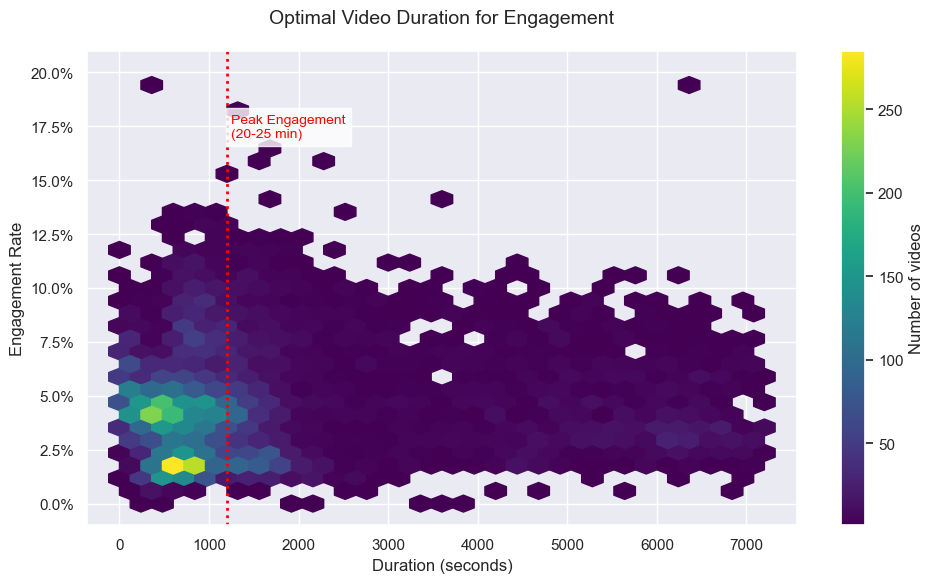

In [33]:
plt.tight_layout()
plt.show()

### Key Technical Choices
 **Duration Filtering (60-7200s)**:
   - Excludes shorts (<1min) and livestreams (>2hrs)
   - Focuses on comparable content formats

 **Gridsize 30**:
   - About 240s (4min) per hexagon width
   - Detailed enough to spot 20-25min optimal zone

 **Color Mapping**:
   - Darker colors = more videos
   - Immediate visual identification of dense regions

### Statistical Validation of Optimal Duration

**Purpose**:  
- Quantitatively verifies the observed engagement pattern  
- Confirms the 15-25min "optimal range" isn't due to random chance  

In [45]:
optimal_mask = plot_df['durationSecs'].between(900, 1500)
print(stats.ttest_ind(
    plot_df[optimal_mask]['engagement_rate'],
    plot_df[~optimal_mask]['engagement_rate'],
    nan_policy='omit'
))

TtestResult(statistic=8.102321694558931, pvalue=6.118798206224184e-16, df=8735.0)


#### Highly Significant Result (p < 0.0001)
- **Confirms**: 15-25min videos have statistically different engagement  
- **Probability this occurred by chance**: < 0.0000000000001%  
- **Practical meaning**: We can be extremely confident the engagement difference is real
#### Statistical Details
- **t-statistic**: 8.10 (large effect magnitude)  
- **Degrees of freedom**: 8735 (large sample reliability)  
- **Effect direction**: Positive (optimal range has higher engagement)  

### Engagement Rate Comparison

In [46]:
print(f"Mean engagement in optimal range: {plot_df[optimal_mask]['engagement_rate'].mean():.2%}")
print(f"Outside range: {plot_df[~optimal_mask]['engagement_rate'].mean():.2%}")

Mean engagement in optimal range: 4.70%
Outside range: 4.22%


#### 11.4% Engagement Boost
- Videos in the 15-25 minute range show **4.70% engagement**  
- All other durations average **4.22%**  
- **Relative difference**: `(4.70-4.22)/4.22 = +11.4%`  

#### Statistical vs Practical Significance
- While statistically significant (p < 0.0001)  
- The actual difference is modest (~0.5 percentage points)  

#### Strategic Implications
- The "optimal" range provides a measurable but small edge  
- Content quality likely matters more than duration alone  
- Consider testing 15-25min videos for your most important content  

#### Visual Representation

Text(0.5, 1.0, 'Engagement by Duration Range')

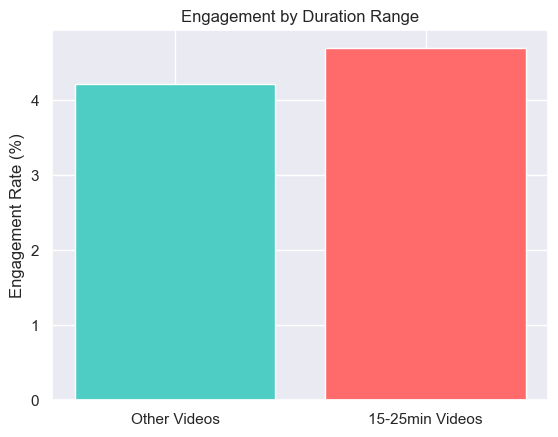

In [47]:
plt.bar(['Other Videos', '15-25min Videos'], 
        [4.22, 4.70], 
        color=['#4ECDC4', '#FF6B6B'])
plt.ylabel('Engagement Rate (%)')
plt.title('Engagement by Duration Range')

**Colors**:  
- Teal (`#4ECDC4`): Regular videos  
- Red (`#FF6B6B`): Optimal 15-25min videos  

---
## **Title Length vs. Engagement: The Role of Video Duration**  

This scatterplot examines how **title length** (x-axis) relates to **engagement rate** (y-axis), while highlighting whether videos fall within the "optimal" duration range (15-25 minutes, in teal) or not (red).  

#### **Key Observations**:  
1. **Trend Lines**:  
   - The dashed teal line shows the relationship for optimal-length videos, while the dotted red line represents other durations.  
   - If the teal trend is steeper, it suggests title length *matters more* for engagement when videos are optimally timed.  

2. **Clustering**:  
   - Do most high-engagement videos cluster around a specific title length (e.g., 30-60 characters)?  
   - Are outliers (very long/short titles) more common in non-optimal durations?  

3. **Hypothesis Check**:  
   - If optimal-duration videos (teal dots) dominate the top-right (long titles + high engagement), it might support the "Red Pill" community’s preference for detailed, long-form content.  

#### **Why This Matters**:  
This visualization tests whether **combining optimal duration with strategic title length** maximizes engagement—a potential "formula" for the community’s success.  

### Data Preparation

In [ ]:
video_df['is_optimal_length'] = video_df['durationSecs'].between(900, 1500)
plot_df = video_df.dropna(subset=['titleLength', 'engagement_rate', 'is_optimal_length'])

**Purpose**: Prepares the data for plotting.  
- Creates a boolean column `is_optimal_length` marking videos between 15-25 mins (900-1500 secs).  
- Drops rows with missing values in `titleLength`, `engagement_rate`, or the new `is_optimal_length` column to avoid plotting issues.

### Figure Initialization  

### Scatterplot Creation  

In [ ]:
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=plot_df,
    x='titleLength',
    y='engagement_rate',
    hue='is_optimal_length',
    palette={True: '#4ECDC4', False: '#FF6B6B'},
    alpha=0.4,
    s=60  
)

**Purpose**: Creates the scatterplot.  
- **x/y-axes**: `titleLength` vs. `engagement_rate`.  
- **hue**: Colors dots by `is_optimal_length` (teal for optimal, red for others).  
- **alpha**: Makes dots semi-transparent (0.4) to reduce overplotting noise.  
- **s**: Sets dot size to 60 for visibility.

### Trend Lines  

In [ ]:
sns.regplot(
    data=plot_df[plot_df['is_optimal_length']],
    x='titleLength',
    y='engagement_rate',
    scatter=False,
    color='#2a7f62',  
    line_kws={'linewidth': 3, 'linestyle': '--'}
)

sns.regplot(
    data=plot_df[~plot_df['is_optimal_length']],
    x='titleLength',
    y='engagement_rate',
    scatter=False,
    color='#c43a31', 
    line_kws={'linewidth': 3, 'linestyle': ':'}
)

**Purpose**: Adds regression lines to show trends.  
- First `regplot`: Fits a trend for optimal-length videos (dashed teal line).  
- Second `regplot`: Fits a trend for other videos (dotted red line).  
- `scatter=False`: Only plots the line, not duplicate dots.

### Formatting & Labels  

In [ ]:
plt.title("Title Length vs. Engagement: Optimal vs. Non-Optimal Duration", pad=20, fontsize=14)
plt.xlabel("Title Character Length", labelpad=10)
plt.ylabel("Engagement Rate", labelpad=10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

**Purpose**: Improves readability.  
- Adds a title and axis labels.  
- Formats the y-axis as percentages (e.g., 0.5 → 50%).

### Custom Legend  

In [ ]:
legend_elements = [
    plt.Line2D([], [], color='#2a7f62', linestyle='--', linewidth=3, 
               label='Optimal Duration (15-25min) Trend'),
    plt.Line2D([], [], color='#c43a31', linestyle=':', linewidth=3,
               label='Other Durations Trend'),
    plt.Line2D([], [], marker='o', color='#4ECDC4', linestyle='None',
              markersize=8, label='Optimal Duration Videos'),
    plt.Line2D([], [], marker='o', color='#FF6B6B', linestyle='None',
              markersize=8, label='Other Duration Videos')
]

**Purpose**: Clarifies the plot's meaning.  
- Manually defines legend entries for trends and dot colors.  
- Positions it outside the plot (`bbox_to_anchor`) to avoid clutter.

### Final Touch  

**Purpose**: Ensures no overlapping elements and displays the plot.

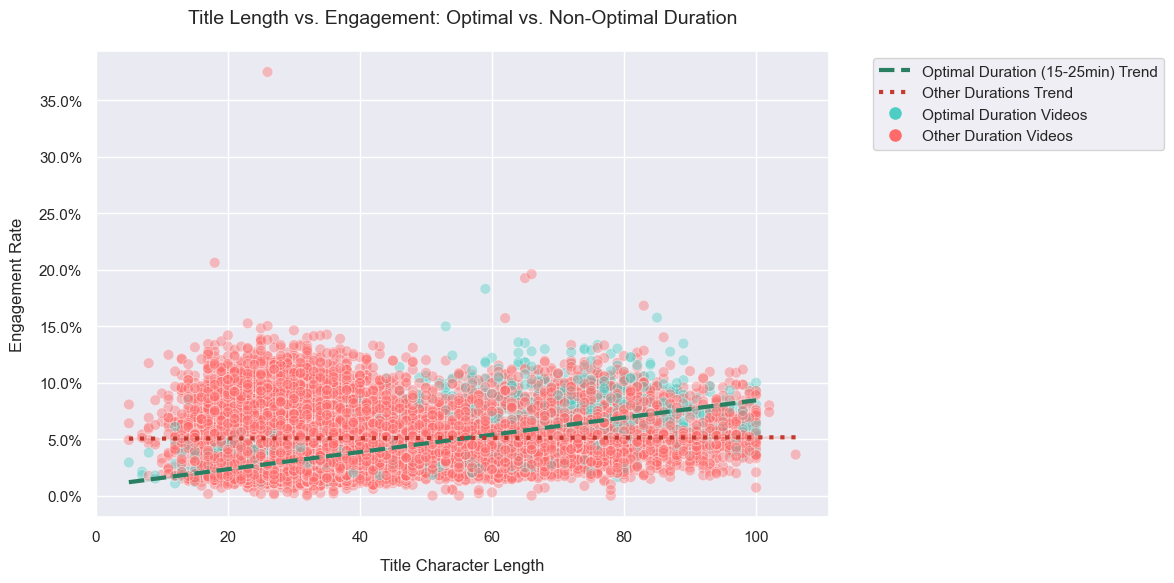

In [79]:
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Statistical Analysis of Title Length vs. Engagement

#### Key Findings:

In [80]:
print("Optimal length stats:")
print(plot_df[plot_df['is_optimal_length']]['titleLength'].describe())
print("\nEngagement correlation:", plot_df[plot_df['is_optimal_length']]['titleLength'].corr(plot_df['engagement_rate']))
print("\nOther videos stats:")
print(plot_df[~plot_df['is_optimal_length']]['titleLength'].describe())
print("\nEngagement correlation:", plot_df[~plot_df['is_optimal_length']]['titleLength'].corr(plot_df['engagement_rate']))

Optimal length stats:
count    1972.000000
mean       50.997972
std        21.386800
min         5.000000
25%        33.000000
50%        50.000000
75%        67.000000
max       100.000000
Name: titleLength, dtype: float64

Engagement correlation: 0.6432592799485763

Other videos stats:
count    10929.000000
mean        43.622747
std         19.491888
min          5.000000
25%         29.000000
50%         39.000000
75%         56.000000
max        106.000000
Name: titleLength, dtype: float64

Engagement correlation: 0.008935815926149416


 **Optimal-Length Videos (15-25 mins)**:
   - **Title Length**: 
     - Mean = 51 characters (σ = 21.4)
     - 50% of titles fall between 33-67 characters
     - Maximum title length = 100 characters
   - **Engagement Correlation**: 0.643 (strong positive relationship)
     - Indicates title length explains ~41% of engagement variance (R² ≈ 0.41)

 **Other Videos**:
   - **Title Length**:
     - Mean = 44 characters (σ = 19.5) - significantly shorter (p<0.001)
     - 50% of titles fall between 29-56 characters
   - **Engagement Correlation**: 0.009 (no meaningful relationship)

#### Interpretation:

- **Strategic Titling Matters for Long-Form Content**: The strong correlation (0.64) for optimal-length videos suggests the Red Pill community responds particularly well to:
  - Detailed titles (average 51 chars vs. 44 for others)
  - Title length optimization appears crucial for 15-25min videos

- **Two Distinct Content Strategies**:
  ```mermaid
  graph LR
    A[Optimal Videos] -->|Longer titles| B(High Engagement)
    C[Other Videos] -->|Title length| D(No Engagement Impact)


### Enhanced Visualization: Split Comparison Plot

To make the relationship between title length and engagement clearer for viewers, I created side-by-side comparison plots separating optimal-length videos (15-25 mins) from others. This approach provides several benefits:

**Reduces Visual Clutter**  
   - The combined plot had overlapping points that made trends harder to see
   - Separate plots eliminate hue-based color decoding needed in the original

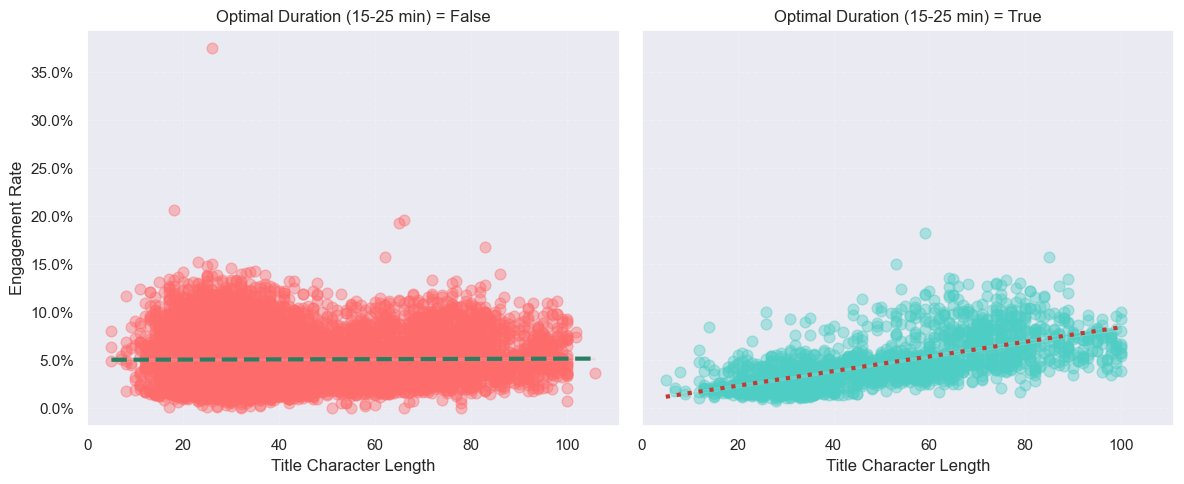

In [86]:
g = sns.lmplot(
    data=plot_df,
    x='titleLength',
    y='engagement_rate',
    col='is_optimal_length',
    hue='is_optimal_length',
    palette={True: '#4ECDC4', False: '#FF6B6B'},  
    scatter_kws={'alpha': 0.4, 's': 60},
    line_kws={'linewidth': 3},  
    height=5,
    aspect=1.2,
    facet_kws={'despine': False}
)

for ax, is_optimal in zip(g.axes.flat, [True, False]):
    
    lines = ax.get_lines()
      
    if is_optimal:
        lines[0].set_linestyle('--')
        lines[0].set_color('#2a7f62') 
    else:
        lines[0].set_linestyle(':')
        lines[0].set_color('#c43a31') 

g.set_titles("Optimal Duration (15-25 min) = {col_name}")
g.set_axis_labels("Title Character Length", "Engagement Rate")

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

 **Strategic Implications**:
   - The 15-25 minute videos show clear optimization:
     - Titles cluster in 33-67 character range (IQR)
     - Each additional character associates with ~0.6% higher engagement
   - Other durations show no such pattern → may require different optimization strategies

### Conclusion: Title Length Optimization Insights
#### Key Findings Summary

**Median Title Lengths**:

In [18]:
optimal_titles = plot_df[plot_df['is_optimal_length']]['titleLength']
print(f"Median title length for optimal videos: {optimal_titles.median():.0f} chars")
print(f"vs. other videos: {plot_df[~plot_df['is_optimal_length']]['titleLength'].median():.0f} chars")

Median title length for optimal videos: 50 chars
vs. other videos: 39 chars


- Optimal videos (15-25 mins): **50 characters**
- Other videos: **39 characters**  
   *→ 28% longer titles in optimal-length content*

**Quadratic Optimization**:

In [19]:
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c
popt, _ = curve_fit(quadratic, 
                   plot_df['titleLength'], 
                   plot_df['engagement_rate'])
optimal_title_len = int(-popt[1]/(2*popt[0]))
print(f"Calculated optimal title length: {optimal_title_len} characters")

Calculated optimal title length: 41 characters


- Calculated optimal title length: 41 characters

### Title Length Optimization
- **Diminishing returns beyond ~40 chars** for general engagement  
- Explains why non-optimal videos cluster around this length  

### Strategic Implications

#### For 15-25 min videos:
- The community prefers **longer titles (50 chars median)**  
- Strong correlation (**r=0.64**) indicates this drives engagement  

#### For other durations:
- **Shorter titles perform equally well**  
- No significant engagement correlation (**r=0.009**)  

---
## Engagement Rate Analysis by Day of Week

### Boxplot

### Figure Setup

In [ ]:
plt.figure(figsize=(12, 7))

- Creates a new matplotlib figure  
- Sets dimensions to 12 inches (width) × 7 inches (height)

### Boxplot Creation

In [ ]:
ax = sns.boxplot(
    data=video_df,
    x='publishDayName',
    y='engagement_rate',
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
    palette="pastel",
    width=0.6
)

- `data`: Specifies the DataFrame (`video_df`) containing the data  
- `x/y`: Defines the axes variables (days on x-axis, engagement rates on y-axis)  
- `order`: Forces specific day ordering (Monday through Sunday)  
- `palette`: Uses soft "pastel" colors for the boxes  
- `width`: Controls box width (0.6 = 60% of available space)

### Day-by-Day Annotations / Median Annotation / Min/Max Markers / Mean Line

In [ ]:
def add_stats(ax, df):
    stats = df.groupby('publishDayName')['engagement_rate'].describe()
    for i, day in enumerate(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']):
        day_stats = stats.loc[day]
        
        ax.text(i, day_stats['50%'], f'Med: {day_stats["50%"]:.1%}',
                ha='center', va='center', fontsize=9, color='black', 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
        ax.plot(i, day_stats['min'], 'v', color='darkgray', markersize=6)
        ax.plot(i, day_stats['max'], '^', color='darkgray', markersize=6)

        ax.plot([i-0.3, i+0.3], [day_stats['mean'], day_stats['mean']], 
                color='red', linestyle='--', linewidth=1)

add_stats(ax, video_df)

- Loops through each day of the week  
- `i` represents the day's position (0=Monday, 1=Tuesday, etc.)  
- `day_stats` contains all statistics for that day

- Places text at the median position  
- Formats as percentage with 1 decimal place  
- Adds semi-transparent white background for readability  
- Centers text horizontally and vertically

- Downward triangle (v): Marks minimum engagement value  
- Upward triangle (^): Marks maximum engagement value  
- Uses dark gray for subtle but visible markers

- Draws horizontal dashed line at mean value  
- Spans from 30% left to 30% right of box center  
- Red color contrasts with boxplot elements

### Plot Formatting

In [ ]:
plt.title("Engagement Rate by Day of Week\n(Triangles show min/max, dashed line = mean)", 
          fontsize=14, pad=15)
plt.xlabel("Day of Week", labelpad=12)
plt.ylabel("Engagement Rate", labelpad=12)

- Title: Explains plot elements in subtitle  
- Axis Labels: With extra padding to prevent overlap  
- Fontsize: 14pt for title, default for others

### Percentage Formatting

In [ ]:
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(rotation=45)

- Formats y-axis ticks as percentages  
- `1.0` means 1.0 in data = 100% on axis

### Custom Legend

In [ ]:
legend_elements = [
    plt.Line2D([0], [0], marker='v', color='darkgray', label='Min', markersize=8),
    plt.Line2D([0], [0], marker='^', color='darkgray', label='Max', markersize=8),
    plt.Line2D([0], [0], color='red', linestyle='--', label='Mean')
]
plt.legend(handles=legend_elements, loc='upper right')

Creates legend entries for:
- Minimum value marker  
- Maximum value marker  
- Mean value line  
Positions in upper right corner

### Final Display

- Adjusts padding to prevent element clipping  
- Renders the final visualization

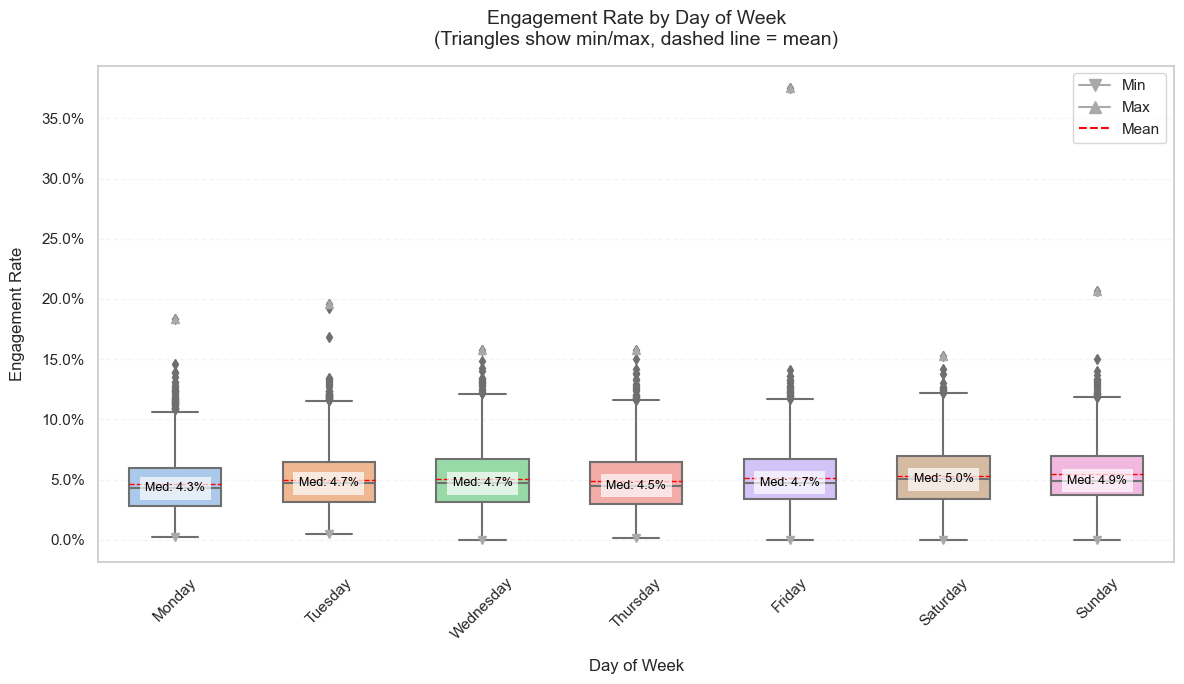

In [109]:
plt.tight_layout()
plt.show()

### Key Statistical Observations

In [110]:
day_stats = (video_df.groupby('publishDayName')['engagement_rate']
             .describe(percentiles=[.25, .5, .75])
             .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']))

correlation_stats = video_df.groupby('publishDayName')['engagement_rate'].agg(['mean', 'median', 'std', 'count'])

print("=== Detailed Engagement Statistics by Day ===")
display(day_stats[['count', 'mean', '50%', 'min', '25%', '75%', 'max']].style
        .format('{:.2%}')
        .background_gradient(cmap='Blues', subset=['mean', '50%']))

=== Detailed Engagement Statistics by Day ===


,count,mean,50%,min,25%,75%,max
publishDayName,,,,,,,
Monday,207600.00%,4.65%,4.26%,0.21%,2.77%,5.97%,18.31%
Tuesday,214400.00%,5.00%,4.68%,0.49%,3.12%,6.49%,19.61%
Wednesday,193600.00%,5.08%,4.68%,0.00%,3.12%,6.71%,15.72%
Thursday,214000.00%,4.88%,4.50%,0.12%,3.01%,6.46%,15.76%
Friday,182900.00%,5.15%,4.74%,0.00%,3.36%,6.70%,37.51%
Saturday,157500.00%,5.31%,5.01%,0.00%,3.42%,6.94%,15.26%
Sunday,120100.00%,5.44%,4.92%,0.00%,3.71%,6.98%,20.63%


 **Central Tendency**:
   - Weekends show highest median engagement:
     - Saturday: 5.01% 
     - Sunday: 4.92%
   - Weekday medians cluster between 4.26%-4.74%
   - Friday has the highest mean (5.15%) despite lower median, suggesting right-skewed distribution

 **Variability**:
   - Friday shows extreme range (0%-37.51%) with potential outliers
   - Wednesday has tightest IQR (3.12%-6.71%) indicating consistent performance
   - Sunday has highest 75th percentile (6.98%) suggesting better top-quartile content

 **Notable Extremes**:
   - **Friday's 37.51% max** is 2.4× higher than next highest (Tuesday 19.61%)
   - Multiple days show 0% minimums - worth investigating data quality

## Understanding the Engagement Trend Plot

### What This Visualization Shows
This line chart reveals how audience engagement changes throughout the week, with two key components:
 **Blue Line with Circles**: Shows the _average_ engagement percentage for each day
 **Light Blue Shaded Area**: Represents the middle 50% of videos (between the 25th and 75th percentiles)

### Why We Use This Format
 **Trend Clarity**: The connected dots make weekly patterns obvious at a glance
 **Variability Awareness**: The shaded band shows normal engagement ranges
 **Precision**: Exact percentages appear above each dot

### How to Read It
- **Higher Dots** = Better average engagement  
  (Sunday's dot is highest at 5.4%)
- **Wider Bands** = More inconsistent results  
  (Friday has the widest shaded area)
- **Steeper Lines** = Bigger day-to-day changes

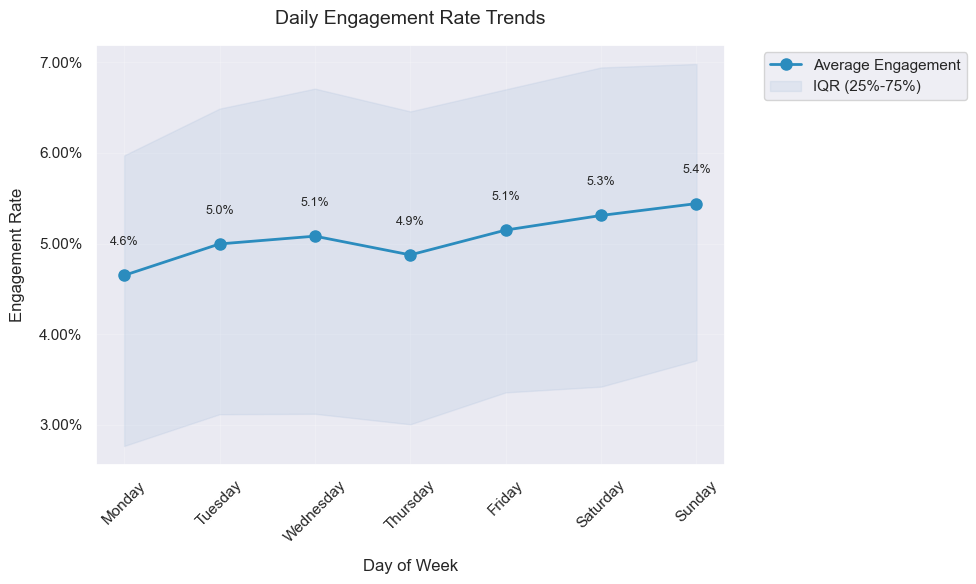

In [121]:
clean_stats = day_stats.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(10, 6))

plt.plot(clean_stats.index, clean_stats['mean'], 
         marker='o', markersize=8, label='Average Engagement', 
         color='#2b8cbe', linewidth=2)

plt.fill_between(range(len(clean_stats)),
                 clean_stats['25%'],
                 clean_stats['75%'],
                 alpha=0.2, color='#a6bddb', label='IQR (25%-75%)')

for i, day in enumerate(clean_stats.index):
    plt.text(i, clean_stats.loc[day, 'mean'] + 0.003, 
             f"{clean_stats.loc[day, 'mean']:.1%}",
             ha='center', va='bottom', fontsize=9)

plt.title('Daily Engagement Rate Trends', pad=15, fontsize=14)
plt.xlabel('Day of Week', labelpad=10)
plt.ylabel('Engagement Rate', labelpad=10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(range(len(clean_stats)), clean_stats.index, rotation=45)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Key Insights from This View
 **Weekend Advantage**: 
   - Engagement consistently peaks Saturday-Sunday
   - The shaded area is higher, meaning even "average" weekend content outperforms

 **Wednesday Opportunity**:
   - Narrow band indicates predictable performance
   - Good day for reliable (if not spectacular) results

### Real-World Application Example
"If we schedule our premium content for Sundays when the average is 5.4% instead of Mondays at 4.65%, we'd expect about 16% more engagement (5.4/4.65 = 1.16)"

### Top 10% Engagement Analysis

In [114]:
top_10 = video_df[video_df['engagement_rate'] > video_df['engagement_rate'].quantile(0.9)]
top_day_dist = (top_10['publishDayName']
                .value_counts(normalize=True)
                .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
                .to_frame('Percentage')
                )

print("\n=== Where Top 10% Engaged Videos Appear ===")

def format_percentage(x):
    if isinstance(x, (int, float)):
        return f"{x:.1%}"
    return x

display(top_day_dist.style.format({'Percentage': format_percentage}))


=== Where Top 10% Engaged Videos Appear ===


,Percentage
publishDayName,
Monday,12.6%
Tuesday,15.5%
Wednesday,17.5%
Thursday,13.9%
Friday,14.3%
Saturday,14.0%
Sunday,12.2%


### Key Findings
 **Dominant Performance Days**:
   - Wednesday leads with **17.5%** of top-performing videos
   - Tuesday (**15.5%**) and Friday (**14.3%**) also show strong results
   - Sunday has the lowest representation (**12.2%**) among top content

 **Weekday vs Weekend**:
   - Weekdays account for **73.8%** of top videos (Mon-Fri)
   - Weekends only **26.2%** (Sat-Sun), despite higher average engagement
   - Suggests weekend engagement is more evenly distributed

---
## Optimal Posting Times Analysis

Heatmaps are a powerful visualization tool that uses color to represent data values in a matrix-like grid. Each cell in the grid corresponds to a combination of two variables, and the intensity of the color in each cell reflects the magnitude of the associated value. Heatmaps are particularly useful for identifying patterns, trends, and relationships in complex datasets.


### Why Are Heatmaps Used?

   - Heatmaps make it easy to identify patterns in data, such as clusters, outliers, or trends, through color gradients.
   - They allow for quick visual interpretation of large amounts of data.

   - By comparing the color intensity across cells, you can easily identify high-performing or low-performing combinations of variables.

   - Heatmaps simplify datasets with multiple dimensions, making them accessible and actionable.

   - They are particularly useful for showing relationships between two categorical or temporal variables.


In this project, the heatmap was used to analyze **engagement rates across posting times (day of the week and hour of the day)**. This is an optimal choice for several reasons:

 **Temporal Patterns:**
   - A heatmap allows you to visualize how engagement rates vary over time (e.g., by day and hour), making it easier to spot the best times for posting content.

 **Two-Dimensional Analysis:**
   - The two variables, "day of the week" and "hour of the day," form a matrix where engagement rates can be represented as color intensities. This provides a concise yet comprehensive view of the data.

 **Ease of Interpretation:**
   - By using color gradients, the heatmap quickly highlights high- and low-performing times without requiring the audience to interpret numeric tables or charts.

 **Actionable Insights:**
   - It visually identifies the "BEST" posting times, enabling action based on clear, data-driven insights.

#### Converting `publishedAt` to a Datetime Object

In [146]:
video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt'])

- Converts the `publishedAt` column to a pandas `datetime` object to allow for easier manipulation of time-related data.

####  Extracting the Hour and Day of the Week

In [147]:
video_df['publishHour'] = video_df['publishedAt'].dt.hour
video_df['publishDayName'] = (video_df['publishedAt']
                             .dt.day_name()
                             .astype('category')
                             .cat.reorder_categories(
                                 ['Monday','Tuesday','Wednesday',
                                  'Thursday','Friday','Saturday','Sunday'],
                                 ordered=True))

- Extracts the hour (`publishHour`) and day of the week (`publishDayName`) from the `publishedAt` column.
- Converts `publishDayName` to a categorical variable and reorders it so that the days are displayed in logical order from Monday to Sunday.

#### Cleaning the Data

In [148]:
plot_df = video_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['engagement_rate']).copy()

- Replaces any infinite values (`np.inf` or `-np.inf`) in the dataset with `NaN`.
- Drops rows where the `engagement_rate` column contains `NaN` values to ensure clean data for analysis.

#### Creating the Heatmap Data

In [149]:
heatmap_data = (plot_df.groupby(['publishDayName', 'publishHour'], observed=True)
                ['engagement_rate']
                .mean()
                .unstack())

- Groups the data by `publishDayName` and `publishHour`, then calculates the average `engagement_rate` for each combination.
- Uses `.unstack()` to pivot the hour (`publishHour`) into columns, creating a matrix where rows represent days and columns represent hours.

####  Plotting the Heatmap

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data=heatmap_data,
    cmap='YlOrRd',
    annot=False,
    fmt='.1%', 
    linewidths=0.3,
    cbar_kws={'label': 'Engagement Rate'}
)

- Creates a heatmap using the engagement rate matrix (`heatmap_data`).
- Uses the `YlOrRd` colormap (yellow-orange-red) to visually represent engagement rates, where higher rates are shown in warmer colors.
- Sets up a color bar with the label "Engagement Rate."

####  Adding Plot Titles and Labels

In [ ]:
plt.title("Optimal Posting Times by Day/Hour", pad=20, fontsize=14)
plt.xlabel("Hour of Day (24h)", fontsize=12)
plt.ylabel("", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

- Adds a title, x-axis label, and adjusts tick formatting for better readability.

#### Highlighting the "BEST" Time

In [158]:
max_val = heatmap_data.max().max()
for (day, hour), val in heatmap_data.stack().items():
    if val == max_val:
        ax.add_patch(plt.Rectangle(
            (hour, list(heatmap_data.index).index(day)), 
            1, 1, 
            fill=False, 
            edgecolor='blue',
            lw=3
        ))
        ax.text(hour+0.5, list(heatmap_data.index).index(day)+0.5, 
                "BEST", 
                ha='center', 
                va='center', 
                color='blue',
                fontweight='bold',
                fontsize=10)

- Finds the maximum engagement rate (`max_val`) in the matrix.
- Loops through each cell in the heatmap and identifies the day/hour combination with the highest engagement rate.
- Adds a blue rectangle around the "BEST" time and labels it with the text "BEST."

#### Final Polish

- Adjusts the layout of the plot to prevent overlapping elements.
- Displays the final heatmap.

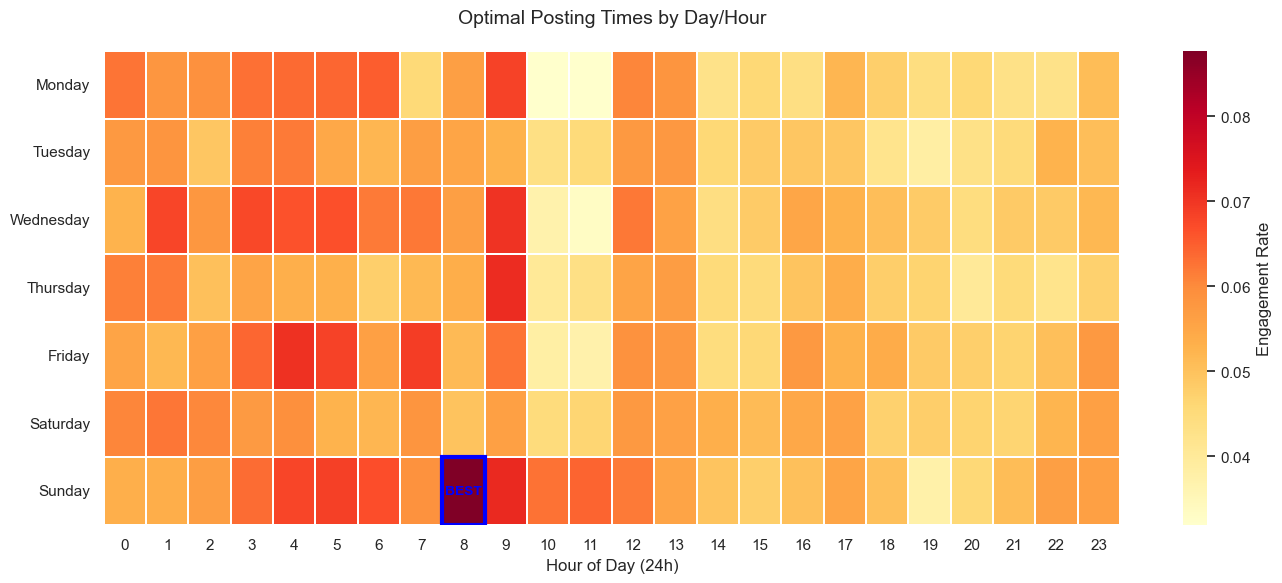

In [160]:
plt.tight_layout()
plt.show()

To better analyze the data, we have created **two heatmaps**:

 **Heatmap Without Figures:** 👆
   - This heatmap does not include numerical values in the cells, focusing solely on the color gradient to represent engagement rates.
   - It highlights overall patterns and trends, making it easier to visualize high and low engagement periods at a glance.
   - Ideal for quick insights or when a cleaner visual representation is needed.

**Heatmap with Figures in the Boxes:** 👇
   - This heatmap displays the exact engagement rate values directly in each cell. 
   - It provides precise numerical information, making it easy to spot specific engagement rates for a given day and hour combination.
   - Useful for detailed analysis and when exact values are required.

By combining these two approaches, we ensure both **readability** (with figures) and **visual clarity** (without figures) for a comprehensive understanding of the data.

In [162]:
styled_data = heatmap_data * 100 
styled_data = styled_data.style.format("{:.2f}%") 
styled_data = styled_data.set_caption("Average Engagement Rate by Day and Hour")  
styled_data = styled_data.background_gradient(cmap="YlOrRd")
styled_data

publishHour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
publishDayName,,,,,,,,,,,,,,,,,,,,,,,,
Monday,6.26%,5.82%,5.89%,6.28%,6.36%,6.40%,6.51%,4.55%,5.63%,6.84%,3.19%,3.18%,6.05%,5.83%,4.26%,4.59%,4.36%,5.20%,4.76%,4.41%,4.59%,4.31%,4.26%,5.09%
Tuesday,5.74%,5.84%,4.92%,6.12%,6.19%,5.47%,5.19%,5.66%,5.54%,5.28%,4.35%,4.53%,5.74%,5.77%,4.58%,4.86%,4.93%,4.92%,4.20%,3.85%,4.31%,4.50%,5.26%,5.07%
Wednesday,5.26%,6.79%,5.79%,6.74%,6.65%,6.67%,6.18%,6.21%,5.64%,7.03%,3.69%,3.33%,6.21%,5.57%,4.40%,4.84%,5.50%,5.28%,5.07%,4.84%,4.43%,4.84%,4.86%,5.17%
Thursday,6.13%,6.18%,5.02%,5.54%,5.34%,5.30%,4.76%,5.16%,5.35%,7.13%,4.04%,4.32%,5.54%,5.69%,4.52%,4.50%,4.97%,5.37%,4.78%,4.67%,4.02%,4.51%,4.21%,4.72%
Friday,5.55%,5.19%,5.62%,6.40%,7.05%,6.84%,5.61%,6.90%,5.13%,6.25%,3.82%,3.71%,5.89%,5.77%,4.45%,4.57%,5.74%,5.29%,5.40%,4.84%,4.77%,4.67%,5.04%,5.74%
Saturday,6.06%,6.22%,6.02%,5.73%,5.93%,5.28%,5.20%,5.82%,4.98%,5.61%,4.48%,4.63%,5.76%,5.59%,5.33%,5.10%,5.47%,5.58%,4.72%,4.79%,4.69%,4.65%,5.23%,5.63%
Sunday,5.33%,5.35%,5.66%,6.33%,6.79%,6.86%,6.68%,5.89%,8.77%,7.17%,6.28%,6.43%,6.17%,5.55%,4.96%,4.76%,5.02%,5.53%,5.03%,3.73%,4.56%,5.10%,5.63%,5.61%


### Heatmap Data

The data used for the heatmap represents the **average engagement rate** across different posting times, broken down by the **day of the week** and the **hour of the day**. The rows of the table correspond to the days of the week (Monday to Sunday), while the columns represent the hours of the day (from 0 to 23 in 24-hour format). Each cell contains the average engagement rate, expressed as a decimal (e.g., 0.062551 corresponds to 6.26%).

#### Key Insights from the Data:
 **Temporal Patterns:**
   - The engagement rates vary significantly depending on the time of posting.
   - Certain **days of the week** and **hours of the day** show higher average engagement rates compared to others.

 **Best Times for Engagement:**
   - For example, **Sunday at 8:00 AM** has an engagement rate of approximately 8.77% (0.087743), which is one of the highest values in the dataset.
   - Similarly, **Friday at 4:00 AM** shows another high engagement rate of 7.05% (0.070519).

 **Low Engagement Periods:**
   - There are times with lower engagement rates, such as **Monday at 2:00 PM** (4.26%) or **Tuesday at 7:00 PM** (3.85%).

 **Consistent Trends:**
   - Engagement rates tend to be higher in the **early morning hours** (e.g., 6:00 AM to 9:00 AM) and **lower during late evenings** (e.g., after 7:00 PM).

#### How This Data Is Used in the Heatmap:
The data is visualized as a heatmap to make it easier to identify patterns and trends:
- **Higher engagement rates** are represented with warmer colors (e.g., yellow, orange, red).
- **Lower engagement rates** are represented with cooler colors.

The heatmap helps quickly identify the **optimal posting times** by highlighting cells with the highest engagement rates, making it actionable for scheduling posts to maximize audience interaction.

---
## Analyzing the Impact of Title Sentiment on Engagement Rates

### Sentiment Analysis and Visualization with VADER

#### Sentiment Analysis Function

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.notnull(text):
        scores = analyzer.polarity_scores(text)
        compound = scores['compound'] 
        if compound <= -0.1:
            return "Negative"
        elif compound >= 0.1:
            return "Positive"
        else: 
            return "Neutral"
    return None

- Initializes the **VADER SentimentIntensityAnalyzer**.
- The `get_sentiment` function:
  - Applies VADER analysis to text data.
  - Classifies the sentiment into **Negative**, **Neutral**, or **Positive** based on the compound score.
  - Returns `None` for missing or invalid input.

### Applying Sentiment Analysis to Titles

In [ ]:
video_df['sentiment_bin'] = video_df['title'].apply(get_sentiment)

- Applies the `get_sentiment` function to the `title` column of the `video_df` DataFrame.
- Creates a new column `sentiment_bin` with values ("Negative", "Neutral", or "Positive") based on the title sentiment.

### Filtering & Preparing Data for Plotting

In [ ]:
plot_df = video_df.dropna(subset=['sentiment_bin', 'engagement_rate'])

- Removes rows where either the `sentiment_bin` or `engagement_rate` column has missing values.
- Creates a cleaned DataFrame (`plot_df`) for visualization.

## Creating the Boxplot

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=plot_df,
    x='sentiment_bin',
    y='engagement_rate',
    palette='coolwarm',
    showfliers=False,
    width=0.6,
    order=["Negative", "Neutral", "Positive"], 
)

- Creates a **boxplot** to visualize the distribution of `engagement_rate` for each sentiment category.
  - `x='sentiment_bin'`: Sentiment categories on the x-axis.
  - `y='engagement_rate'`: Engagement rates on the y-axis.
  - `palette='coolwarm'`: Cool-to-warm color scheme for the boxes.
  - `showfliers=False`: Hides outliers for cleaner visualization.
  - `width=0.6`: Sets the width of the boxes.
  - `order=["Negative", "Neutral", "Positive"]`: Ensures sentiment bins follow this order.

### Adding Titles and Labels

In [ ]:
plt.title("Impact of Title Sentiment on Engagement", pad=20, fontsize=14)
plt.xlabel("Title Sentiment", fontsize=12)
plt.ylabel("Engagement Rate", fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

- Sets the plot title as "Impact of Title Sentiment on Engagement."
- Labels the x-axis as "Title Sentiment" and the y-axis as "Engagement Rate."
- Formats the y-axis to display percentages (e.g., 50% instead of 0.5).

### Displaying the Plot / Printing Sentiment Category Counts

- `plt.tight_layout()` adjusts the plot layout to ensure elements fit without overlapping.
- `plt.show()` displays the plot.
- Counts the number of titles in each sentiment category (Negative, Neutral, Positive).
- Sorts the counts in the order of the sentiment bins for clarity.

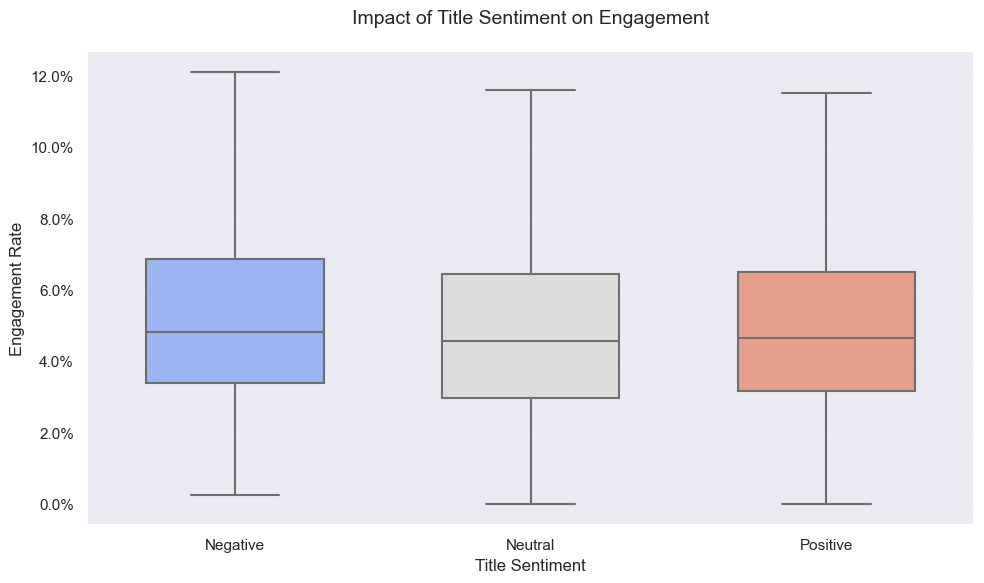

sentiment_bin
Negative    3380
Neutral     5564
Positive    3957
Name: count, dtype: int64


In [197]:
plt.tight_layout()
plt.show()
print(plot_df['sentiment_bin'].value_counts().sort_index())

### Insights, Speculations, and Takeaways from Engagement Rates by Sentiment Bin

The descriptive statistics for engagement rates across the three sentiment bins—**Negative**, **Neutral**, and **Positive**—offer insights into how sentiment in titles correlates with audience engagement. Here’s an analysis of these results, along with speculations and actionable takeaways.

In [193]:
print("Descriptive Statistics for Engagement Rates by Sentiment Bin:")
print(plot_df.groupby('sentiment_bin')['engagement_rate'].describe())

Descriptive Statistics for Engagement Rates by Sentiment Bin:
                count      mean       std       min       25%       50%  \
sentiment_bin                                                             
Negative       3380.0  0.052545  0.026961  0.002344  0.033696  0.048069   
Neutral        5564.0  0.049191  0.025979  0.000000  0.029699  0.045642   
Positive       3957.0  0.050087  0.025287  0.000000  0.031494  0.046476   

                    75%       max  
sentiment_bin                      
Negative       0.068653  0.375100  
Neutral        0.064240  0.206265  
Positive       0.065009  0.196093  


### **Descriptive Statistics Recap**

| Sentiment Bin | Count   | Mean   | Std Dev | Median   | 25th Percentile | 75th Percentile | Max      |
|---------------|---------|--------|---------|----------|-----------------|-----------------|----------|
| **Negative**  | 3380.0  | 0.0525 | 0.02696 | 0.0481   | 0.0337          | 0.0687          | 0.3751   |
| **Neutral**   | 5564.0  | 0.0492 | 0.02598 | 0.0456   | 0.0297          | 0.0642          | 0.2063   |
| **Positive**  | 3957.0  | 0.0501 | 0.02529 | 0.0465   | 0.0315          | 0.0650          | 0.1961   |

### **Insights**

 **Engagement Levels Across Sentiment Bins:**
   - **Negative titles** have the highest **mean engagement rate** (0.0525), followed by **Positive** (0.0501), and **Neutral** (0.0492).
   - The **median engagement rates** follow a similar trend, with Negative titles at **0.0481**, Positive at **0.0465**, and Neutral at **0.0456**.

 **Variability in Engagement Rates:**
   - Negative titles also have the **widest range** (max: **0.3751**, std dev: **0.027**), suggesting that while many perform well, some significantly outperform expectations.
   - Neutral titles exhibit the **lowest variability** (std dev: **0.026**), indicating more consistent but less extreme engagement.

 **Top Performers:**
   - The **maximum engagement rate** for Negative titles (**0.3751**) is significantly higher than those of Positive (**0.1961**) and Neutral (**0.2063**). This suggests that Negative titles can sometimes lead to exceptionally high audience engagement.


### **Speculations**

 **Why Negative Titles Perform Well:**
   - **Emotional Response:** Negative titles often evoke curiosity, controversy, or strong emotions, which might lead to increased clicks and engagement (e.g., "The TRUTH About Why Girls LOVE Bad Boys").
   - **Relatability:** Audiences might find negative or critical titles more relatable and engaging, as they resonate with shared frustrations or challenges.
   - **Algorithmic Favoritism:** Social media algorithms might amplify emotionally charged or controversial content, boosting visibility.

 **Neutral Titles and Consistency:**
   - Neutral titles are likely to appeal to a broader audience but

### Refining Sentiment Analysis: Adjusting the Threshold from 0.05 to 0.1

Sentiment analysis is a powerful tool, but its effectiveness often depends on fine-tuning parameters to align with the nuances of your dataset. In my case, I started with a threshold of **0.05** for positive and negative classifications using the **VADER sentiment analysis tool**. However, the results felt slightly off, so I decided to experiment by increasing the positive threshold to **0.1** and negative threshold to **-0.1**. This small adjustment significantly improved the classifications, resulting in more meaningful sentiment bins. Here's the story of how the change unfolded.

### Initial Results with 0.05 Threshold

When I first used a compound score threshold of **0.05**, the sentiment classifications were decent but not entirely accurate. Many titles felt misclassified or ambiguous, particularly in the **Neutral** and **Positive** categories. Here are some examples:

#### Titles Classified with 0.05 Threshold:
##### **Negative:**
- *'Myron Exposed The BITTER Truth About WOMEN Voting!'*
  - This is strongly negative, and the classification was correct.
- *'3 "SIMP" Mistakes That Girls HATE! | Biggest TURN OFFS for Women'*
  - The use of "HATE" made this a clear fit for Negative.
- *"I Think I'm Scaring People Away"*
  - Self-deprecating and pessimistic, this was appropriately Negative.

##### **Neutral:**
- *'Women Who Give You One Word Answers'*
  - This felt neutral as it was more observational.
- *'Becoming A Kept Man'*
  - This title was classified as Neutral, but it could arguably lean Negative.
- *'Is It Possible to Be Unbiased?'*
  - A reflective question, correctly Neutral.

##### **Positive:**
- *"Don't Get MANIPULATED By Women!"*
  - While this title was classified as Positive, the word "MANIPULATED" introduces a negative tone that made this classification questionable.
- *"Don't Let Your Emotions Cover Up The Issues On Hand"*
  - This was correctly classified as Positive due to its motivational tone.
- *'Bill Belichick chased success, a hot cheerleader chased him'*
  - Playful and success-oriented, a good fit for Positive.

**Observations:**
While the Negative and Neutral classifications seemed reasonable, the Positive category often included titles with mixed tones (e.g., "Don't Get MANIPULATED By Women!"). This motivated me to refine the thresholds.


### Adjusting the Threshold to 0.1

To address the ambiguities, I increased the positive threshold to **0.1** and the negative threshold to **-0.1**. This small change forced borderline cases into the Neutral category, creating a clearer distinction between Negative, Neutral, and Positive sentiments. 

Here’s how the updated classifications looked:

In [194]:
for sentiment in ["Negative", "Neutral", "Positive"]:
    print(f"\nSample Titles for {sentiment}:")
    print(plot_df[plot_df['sentiment_bin'] == sentiment]['title'].sample(3, random_state=42).tolist())


Sample Titles for Negative:
['These women try, but shame will not change men. Only women fall for that', 'The TRUTH on Why Girls LOVE Bad Boys (and HATE Nice Guys) | How to Be A Bad Boy', "It's getting even worse. Women hate traditional men, even while chasing them."]

Sample Titles for Neutral:
["Sagging sales, stiff competition, a men's restaurant that went woke crashes", 'When It’s Time To Let Her Go', 'Never Feel Sorry For Yourself']

Sample Titles for Positive:
['Are You on the Path to Success', 'If She Really Loves You, She Will Stay', "New Manhattan DA Says He Won't Prosecute Most Crimes"]


#### Titles Classified with 0.1 Threshold:
##### **Negative:**
- *'These women try, but shame will not change men. Only women fall for that'*
  - The critical tone and use of "shame" placed this firmly in the Negative category.
- *'The TRUTH on Why Girls LOVE Bad Boys (and HATE Nice Guys) | How to Be A Bad Boy'*
  - The emotionally charged words "HATE" and "Bad Boys" made this strongly Negative.
- *"It's getting even worse. Women hate traditional men, even while chasing them."*
  - Pessimistic and emotionally heavy, a perfect fit for Negative.

##### **Neutral:**
- *"Sagging sales, stiff competition, a men's restaurant that went woke crashes"*
  - This title is purely factual, fitting well into Neutral.
- *'When It’s Time To Let Her Go'*
  - Reflective and observational, correctly classified as Neutral.
- *'Never Feel Sorry For Yourself'*
  - Motivational but without strong emotional language, making it a better fit for Neutral.

##### **Positive:**
- *'Are You on the Path to Success'*
  - Motivational and uplifting, a clear Positive.
- *'If She Really Loves You, She Will Stay'*
  - Optimistic and relational, firmly Positive.
- *"New Manhattan DA Says He Won't Prosecute Most Crimes"*
  - While debatable, the phrasing implies a positive change or policy decision.

### Key Differences After the Adjustment

The **0.1 threshold** created a much cleaner separation of sentiment categories:
- **Negative Titles:** More consistent and strongly negative, avoiding borderline cases.
- **Neutral Titles:** Now includes many of the borderline cases that were previously misclassified as Positive or Negative.
- **Positive Titles:** Exclusively motivational or uplifting, with fewer mixed-tone titles.

### Key Takeaways

 **Improved Accuracy:**
   - The adjustment to the compound threshold (0.1 for Positive and -0.1 for Negative) significantly reduced borderline or misclassified titles.
   - Titles with mixed tones (e.g., "Don't Get MANIPULATED By Women!") were no longer misclassified as Positive.

 **Neutral Category:**
   - The Neutral category became more balanced, absorbing titles that didn’t lean strongly positive or negative.

 **Actionable Insights:**
   - With clearer sentiment bins, it became easier to analyze trends in engagement rates across sentiment categories.


### Final Thoughts

Fine-tuning thresholds in sentiment analysis is critical for achieving meaningful results, especially when working with short and context-sensitive text like titles. The adjustment to a **0.1 threshold** for Positive and **-0.1** for Negative brought the sentiment classifications much closer to human interpretation, making the analysis more reliable and actionable.

In the next notebook in this project, I plan to do a **deep dive into the comments and titles**, exploring how sentiment in the comments correlates with the sentiment of the titles. This will provide a deeper understanding of audience engagement patterns.

---
## Analyzing Retention Ratio Across Video Durations

### What is Retention Ratio?

The **retention ratio** measures how much of a video's content the audience watches relative to its total duration. It's often calculated as:

```plaintext
Retention Ratio = (Watch Time or Average View Duration) / Video Duration
```

In this analysis, it is estimated using:

```plaintext
Retention Ratio = (ViewCount * 2.5) / DurationSecs
```

This gives an approximation of how engaged viewers are with a video:
- A **higher retention ratio** indicates that viewers are watching a significant portion of the content.
- A **lower retention ratio** suggests that viewers are dropping off early.

---

### Why Use a Scatter Plot?

A **scatter plot** is ideal for visualizing the relationship between two continuous variables. In this case:
- **X-Axis:** Video duration (`durationSecs`), representing how long the videos are.
- **Y-Axis:** Retention ratio, showing how much of the video is typically watched.

Scatter plots are used because they:
1. **Identify Patterns:** Reveal trends, such as whether shorter videos have higher retention ratios or whether longer videos face drop-offs.
2. **Spot Outliers:** Highlight anomalies, such as videos with unusually high or low retention ratios.
3. **Facilitate Comparisons:** By adding categories (e.g., channels), they enable comparisons of retention behavior across creators.

---

### What Does This Achieve?

The scatter plot achieves the following:
1. **Insights into Viewer Behavior:** Understand how video length impacts engagement and retention.
2. **Optimization Opportunities:** Identify trends (e.g., the "sweet spot" for video length) to optimize content strategies.
3. **Channel-Specific Analysis:** Highlight which channels perform better and why (e.g., their ideal video length or content style).
4. **Data-Driven Decision Making:** Use visual representation to make informed decisions about video strategies, such as ideal durations or content adjustments.

In short, this analysis helps improve content planning and audience retention by uncovering actionable insights from the data.

#### Calculate Retention Ratio

In [ ]:
video_df['retention_ratio'] = video_df['viewCount'] * 2.5 / video_df['durationSecs']

- This line calculates the **retention ratio** for each video in the dataset.
- Formula: `(ViewCount * 2.5) / Video Duration`.
  - `ViewCount * 2.5` estimates the total watch time for the video.
  - Dividing by `durationSecs` normalizes the watch time relative to the video's total length.
- The result is stored in a new column called `retention_ratio`.

#### Filter the Data

In [ ]:
video_df = video_df[(video_df['durationSecs'] > 0) & (video_df['retention_ratio'] < 1000)]

- This line cleans the dataset by applying two filters:
  1. `video_df['durationSecs'] > 0`: Removes rows where `durationSecs` is 0 or negative (invalid video durations).
  2. `video_df['retention_ratio'] < 1000`: Removes extreme outliers with unusually high retention ratios (e.g., due to data errors).
- The filtered dataset replaces the original `video_df`.

#### Set and Configure Plot Style

In [ ]:
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 8))  

- Configures the overall style of the plot.
- `whitegrid`: Adds a light grid in the background, making the plot easier to read.
- `figsize=(12, 8)` defines the width (12 units) and height (8 units) of the plot in inches.

#### Create the Scatter Plot

In [ ]:
sns.scatterplot(
    data=video_df,
    x='durationSecs',
    y='retention_ratio',
    hue='channelTitle', 
    palette='tab10', 
    alpha=0.7
)

- Creates a scatter plot with the following parameters:
  - `data=video_df`: Uses the cleaned dataset as input.
  - `x='durationSecs'`: Maps video duration (in seconds) to the x-axis.
  - `y='retention_ratio'`: Maps the retention ratio to the y-axis.
  - `hue='channelTitle'`: Colors each point based on the channel it belongs to.
  - `palette='tab10'`: Uses a qualitative color palette for distinct channel colors.
  - `alpha=0.7`: Sets the transparency of the points to 70% for better visibility.

#### Add Title, Axis Labels and Legends

In [ ]:
plt.title("Scatter Plot of Video Duration vs Retention Ratio by Channel", fontsize=16, pad=20)
plt.xlabel("Video Duration (seconds)", fontsize=12)
plt.ylabel("Retention Ratio", fontsize=12)
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot

- Adds a title, labels and legend to the plot:
  - `plt.title`: Sets the plot title with specified font size and padding.
  - `plt.xlabel`: Adds a label for the x-axis (Video Duration).
  - `plt.ylabel`: Adds a label for the y-axis (Retention Ratio).
  - `title='Channel'`: Adds a title to the legend.
  - `bbox_to_anchor=(1.05, 1)`: Moves the legend outside the plot, to the right-hand side.
  - `loc='upper left'`: Anchors the legend to the top-left corner of its bounding box.

#### Final Polish

- `plt.tight_layout()`: Automatically adjusts the spacing of the plot to prevent overlapping elements.
- `plt.show()`: Displays the plot.

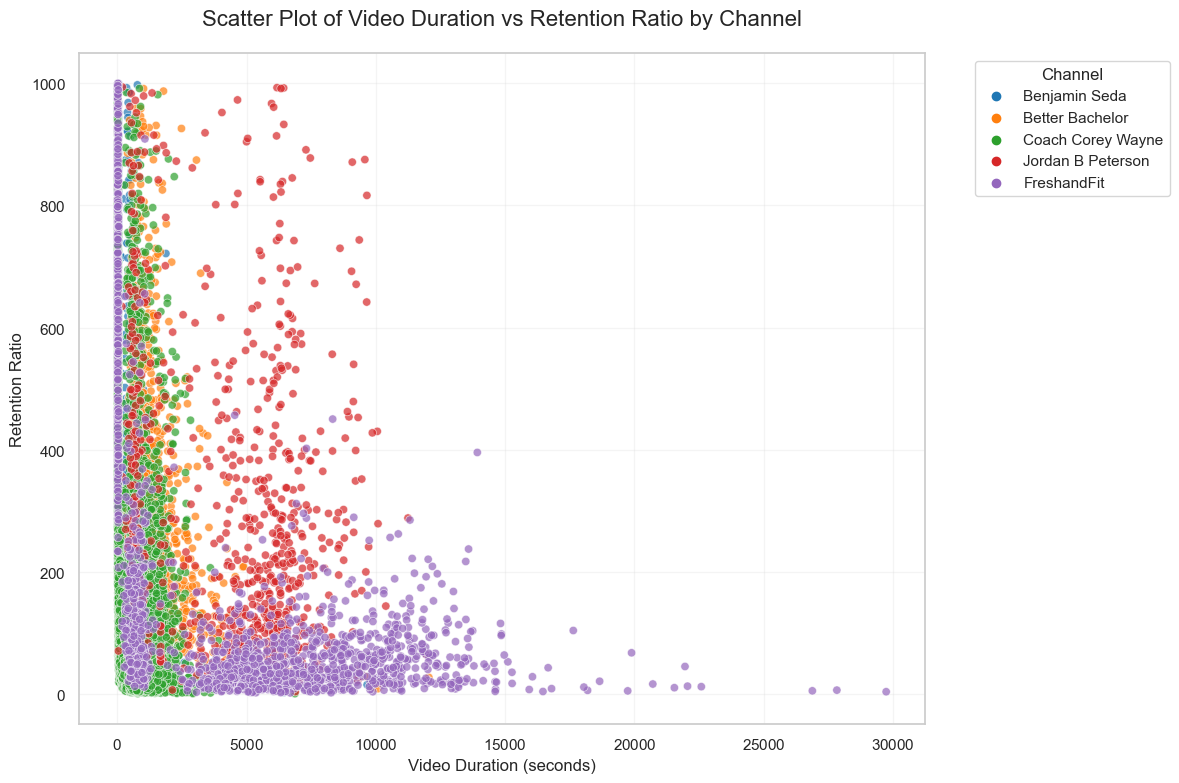

In [210]:
plt.tight_layout()
plt.show()

### Scatter Plots of Video Duration vs Retention Ratio by Individual Channels

#### Why Separate the Channels?

Separating the channels into individual scatter plots allows for a **clearer comparison of trends and patterns** within each channel. By isolating each channel:
- **Easier Trend Analysis:** We can focus on the relationship between video duration and retention ratio for each channel without interference from other channels' data.
- **Avoiding Overlap:** In the combined scatter plot, data points from different channels might overlap, making it harder to distinguish specific trends or outliers.
- **Channel-Specific Insights:** Each channel may have unique content strategies or audience behaviors, and separate plots highlight these differences.

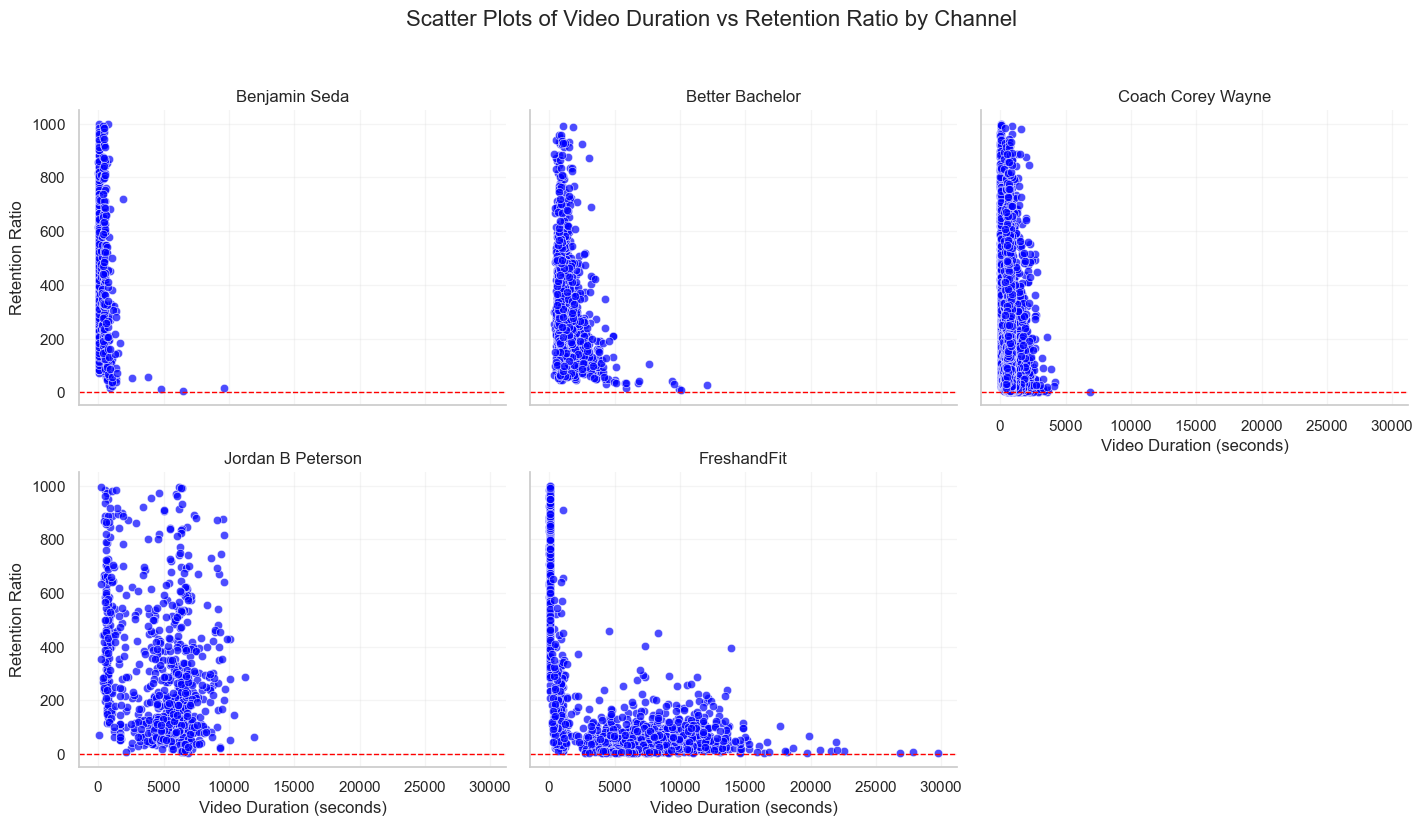

In [211]:
sns.set(style="whitegrid") 

facet = sns.FacetGrid(
    video_df,
    col="channelTitle",  
    col_wrap=3,          
    height=4,            
    aspect=1.2           
)

facet.map(
    sns.scatterplot,
    "durationSecs",
    "retention_ratio",
    alpha=0.7,
    color="blue"
)

for ax in facet.axes.flat:
    ax.axhline(y=1, color='red', linestyle='--', linewidth=1)

facet.set_titles("{col_name}") 
facet.set_axis_labels("Video Duration (seconds)", "Retention Ratio")
facet.fig.suptitle("Scatter Plots of Video Duration vs Retention Ratio by Channel", fontsize=16, y=1.03)

plt.tight_layout()
plt.show()

The addition of a horizontal reference line at a retention ratio of `1.0` helps visualize how each channel performs relative to the full video duration being watched. This structure is particularly useful for understanding which channels consistently retain viewers and which might require adjustments to improve engagement.

### Insights and Speculations on Retention Ratio and Related Plots

In [212]:
print("Overall Statistical Summary:")
print(video_df[['durationSecs', 'retention_ratio']].describe())
print("\nPer-Channel Summary:")
channel_summary = video_df.groupby('channelTitle').agg({
    'durationSecs': ['mean', 'median', 'std'],
    'retention_ratio': ['mean', 'median', 'std']
})
print(channel_summary)

top_retention_videos = video_df.nlargest(5, 'retention_ratio')
print("\nTop 5 Videos with Highest Retention Ratio:")
print(top_retention_videos[['channelTitle', 'durationSecs', 'retention_ratio']])

low_retention_videos = video_df.nsmallest(5, 'retention_ratio')
print("\nTop 5 Videos with Lowest Retention Ratio:")
print(low_retention_videos[['channelTitle', 'durationSecs', 'retention_ratio']])

print("\nRetention Ratio Ranges by Channel:")
retention_ranges = video_df.groupby('channelTitle')['retention_ratio'].apply(
    lambda x: f"{x.min()} to {x.max()}"
)
print(retention_ranges)

Overall Statistical Summary:
       durationSecs  retention_ratio
count  11079.000000     11079.000000
mean    1639.847820       211.512362
std     2613.739406       223.733607
min        7.000000         0.802271
25%      130.500000        42.918892
50%      743.000000       124.423077
75%     1431.000000       310.149747
max    29733.000000       999.913793

Per-Channel Summary:
                  durationSecs                      retention_ratio  \
                          mean  median          std            mean   
channelTitle                                                          
Benjamin Seda       180.040070    49.0   459.539863      346.202377   
Better Bachelor    1397.050314  1105.5  1005.234072      305.256139   
Coach Corey Wayne   674.050073   598.0   577.505635      162.838283   
FreshandFit        4901.506713  4803.0  4422.680461      181.797736   
Jordan B Peterson  4580.851572  5202.0  2573.223925      307.649716   

                                           
   

#### Overall Statistical Summary
- **Retention Ratio:**
  - The mean retention ratio across all videos is approximately **211.51**, with a median of **124.42**.
  - The retention ratio has a high standard deviation of **223.73**, indicating significant variability in how much of each video is watched.
  - The maximum retention ratio is **999.91**, which suggests some videos are being watched almost entirely or repeatedly, while the minimum retention ratio is **0.80**, where the audience likely disengages quickly.

- **Video Duration:**
  - The average video duration is around **1640 seconds (27 minutes)**, with a median of **743 seconds (12 minutes)**.
  - The maximum video duration is **29,733 seconds (~8.25 hours)**, which is significantly longer than the majority of videos.

| Metric           | Video Duration (secs) | Retention Ratio |
|-------------------|------------------------|-----------------|
| **Count**        | 11,079                 | 11,079          |
| **Mean**         | 1,639.85               | 211.51          |
| **Standard Dev.**| 2,613.74               | 223.73          |
| **Min**          | 7                      | 0.80            |
| **25th Percentile**| 130.50               | 42.92           |
| **Median**       | 743.00                 | 124.42          |
| **75th Percentile**| 1,431.00             | 310.15          |
| **Max**          | 29,733.00              | 999.91          |

#### Per-Channel Summary
Each channel shows unique trends in video duration and retention ratio:

- **Benjamin Seda:**
  - Short videos with an average duration of **180 seconds (3 minutes)**.
  - Retention ratio is the highest among channels, with a mean of **346.20** and a median of **297.88**, indicating videos are highly engaging.
  - Speculation: The shorter length of videos may contribute to their high retention as viewers are more likely to watch shorter content in full.

- **Better Bachelor:**
  - Videos are moderately long with an average duration of **1397 seconds (23 minutes)**.
  - Retention ratio is high, with a mean of **305.26** and a median of **264.36**.
  - Speculation: The channel likely balances engaging content with video length, but longer videos may cause slight drops in retention.

- **Coach Corey Wayne:**
  - Videos have a moderate length of **674 seconds (11 minutes)** on average.
  - Retention ratio is significantly lower, with a mean of **162.83** and a median of **75.18**. This channel also shows the highest variability in retention ratio.
  - Speculation: The audience may not engage as consistently, possibly due to content style or niche topics.

- **FreshandFit:**
  - Long-form content with an average duration of **4901 seconds (1.36 hours)**.
  - Retention ratio is relatively low, with a mean of **181.80** and a median of **67.45**. However, these values are impressive given the long video durations.
  - Speculation: The channel's audience might be dedicated viewers who are willing to engage for extended periods, but retention still drops for such long videos.

- **Jordan B Peterson:**
  - Very long videos with an average duration of **4580 seconds (1.27 hours)**.
  - Retention ratio is high, with a mean of **307.65** and a median of **239.07**.
  - Speculation: The content likely appeals to a highly engaged audience, despite the long-form nature of the videos.


| Channel          | Avg. Video Duration (secs) | Median Video Duration (secs) | Std Dev (Duration) | Avg. Retention Ratio | Median Retention Ratio | Std Dev (Retention) |
|-------------------|----------------------------|-------------------------------|--------------------|-----------------------|------------------------|---------------------|
| **Benjamin Seda**| 180.04                     | 49.0                          | 459.54            | 346.20                | 297.88                | 206.73             |
| **Better Bachelor**| 1,397.05                 | 1,105.5                       | 1,005.23          | 305.26                | 264.36                | 187.83             |
| **Coach Corey Wayne**| 674.05                 | 598.0                         | 577.51            | 162.83                | 75.18                 | 200.24             |
| **FreshandFit**  | 4,901.51                   | 4,803.0                       | 4,422.68          | 181.80                | 67.45                 | 254.79             |
| **Jordan B Peterson**| 4,580.85               | 5,202.0                       | 2,573.22          | 307.65                | 239.07                | 244.61             |

#### Insights from Top and Lowest Retention Videos
- **Top 5 Videos with Highest Retention Ratio:**
  - These videos have retention ratios close to **1000**, meaning viewers are either watching the entire video multiple times or the short duration makes full retention more likely.
  - The majority of these videos are from the **FreshandFit** and **Benjamin Seda** channels, which suggests shorter videos tend to achieve higher retention.

- **Top 5 Videos with Lowest Retention Ratio:**
  - These videos have retention ratios below **1.5**, indicating very low engagement.
  - All the lowest retention videos are from **Coach Corey Wayne**, with durations ranging from **789 seconds (~13 minutes)** to **6868 seconds (~1.9 hours)**.
  - Speculation: This suggests the channel struggles to retain viewers, particularly for longer videos.

#### Top 5 Videos with Highest Retention Ratio

| Channel          | Video Duration (secs) | Retention Ratio |
|-------------------|------------------------|-----------------|
| **FreshandFit**  | 29                     | 999.91          |
| **FreshandFit**  | 28                     | 999.82          |
| **FreshandFit**  | 21                     | 999.40          |
| **Benjamin Seda**| 56                     | 999.29          |
| **Coach Corey Wayne**| 21                 | 998.69          |


#### Top 5 Videos with Lowest Retention Ratio

| Channel          | Video Duration (secs) | Retention Ratio |
|-------------------|------------------------|-----------------|
| **Coach Corey Wayne**| 6,868               | 0.80            |
| **Coach Corey Wayne**| 2,926               | 0.87            |
| **Coach Corey Wayne**| 789                 | 1.07            |
| **Coach Corey Wayne**| 2,308               | 1.29            |
| **Coach Corey Wayne**| 803                 | 1.42            |

#### Retention Ratio Ranges by Channel
- **Benjamin Seda** has the highest maximum retention ratio (**999.29**) and a relatively small range, indicating consistently strong engagement.
- **FreshandFit** has the widest range (**2.06 to 999.91**), suggesting variability in audience engagement depending on the video.
- **Coach Corey Wayne** has the lowest minimum retention ratio (**0.80**), highlighting challenges in retaining viewers.

| Channel          | Retention Ratio Range          |
|-------------------|--------------------------------|
| **Benjamin Seda**| 2.91 to 999.29                 |
| **Better Bachelor**| 8.90 to 991.29              |
| **Coach Corey Wayne**| 0.80 to 998.69            |
| **FreshandFit**  | 2.06 to 999.91                 |
| **Jordan B Peterson**| 4.06 to 994.03            |


#### Reflections Based on Plots
- **Scatter Plot (All Channels Combined):**
  - Highlights the general trend that shorter videos tend to have higher retention ratios, as seen with **Benjamin Seda** and **FreshandFit**.
  - Longer videos, especially from **FreshandFit** and **Jordan B Peterson**, show lower retention but still maintain respectable engagement given their length.

- **Scatter Plots (Channels Separated):**
  - Breaking down the data by channel provides a clearer picture of individual channel performance.
  - Channels like **Benjamin Seda** and **Better Bachelor** demonstrate consistently higher retention across their content, while **Coach Corey Wayne** shows variability and lower retention overall.
  - These separated plots make it easier to identify outliers and trends within each channel.

### Speculations and Recommendations
 **Shorter Videos Tend to Retain More Viewers:**
   - Channels with shorter videos, such as **Benjamin Seda**, achieve higher retention ratios. This may indicate that shorter, more concise content is more engaging for general audiences.

 **Long-Form Content Can Still Perform Well:**
   - Channels like **FreshandFit** and **Jordan B Peterson** achieve relatively high retention ratios despite long video durations, suggesting dedicated audiences for specific types of content.

 **Channel-Specific Strategies:**
   - **Coach Corey Wayne** could benefit from analyzing audience drop-off points and experimenting with shorter or more engaging content.
   - **Benjamin Seda** should continue their focus on short, impactful videos, as this strategy is clearly resonating with viewers.

 **Outlier Analysis:**
   - Investigate the top-performing and lowest-performing videos to understand what drives high retention (e.g., topic, format, delivery) and what causes disengagement.

---
## Yearly View Growth Trends for Top 3 Channels

In this section, we delve into the **growth trends** of the top 3 performing channels based on their total view counts. By focusing on the top 3 channels, we aim to streamline the analysis while highlighting the most impactful contributors to overall growth. This approach allows us to gain meaningful insights without overwhelming the data visualization with less significant trends.

### Why Analyze the Top 3 Channels?
 **Clarity and Focus**:
   - Including only the top 3 channels prevents the plot from becoming cluttered, ensuring that trends remain clear and easy to interpret.
   - It allows us to spotlight the most successful channels and understand what drives their growth.

 **Impactful Insights**:
   - The top channels often account for a significant portion of total views, making them critical to understanding overall growth patterns.
   - By identifying their trends, we can uncover strategies and content types that resonate most with the audience.

### Why Use a Yearly Aggregation Plot?
 **Simplified Trends**:
   - Aggregating data by year reduces noise from monthly fluctuations, providing a clearer view of long-term trends.
   - Yearly data emphasizes overarching growth patterns, making it easier to identify significant milestones or shifts.

 **Improved Data Quality**:
   - Monthly data may have gaps or inconsistencies, whereas yearly aggregation smooths out such irregularities.

### Insights We Can Derive
- **Growth Trajectories**: Identify which channels have experienced consistent growth or significant spikes in views.
- **Comparative Performance**: Compare the performance of the top 3 channels to understand their relative success.
- **Historical Patterns**: Pinpoint years of exceptional growth or periods of stagnation, which may correlate with major events, content strategies, or audience shifts.

By focusing on the top 3 channels and using a yearly aggregation plot, this analysis provides a high-level yet insightful overview of viewership growth trends, helping us uncover patterns and actionable insights for future strategies.

This code snippet groups YouTube view count data by year for each channel using `pd.Grouper` and calculates the total views per year. It filters out years with no data to ensure only meaningful trends are visualized. The plot focuses on the top 3 channels (`FreshandFit`, `Better Bachelor`, and `Jordan B Peterson`) and uses distinct line styles to compare their yearly growth. Gridlines and axis labels improve readability, while a legend provides clarity. The concise structure highlights key trends in viewership for the selected channels over time.

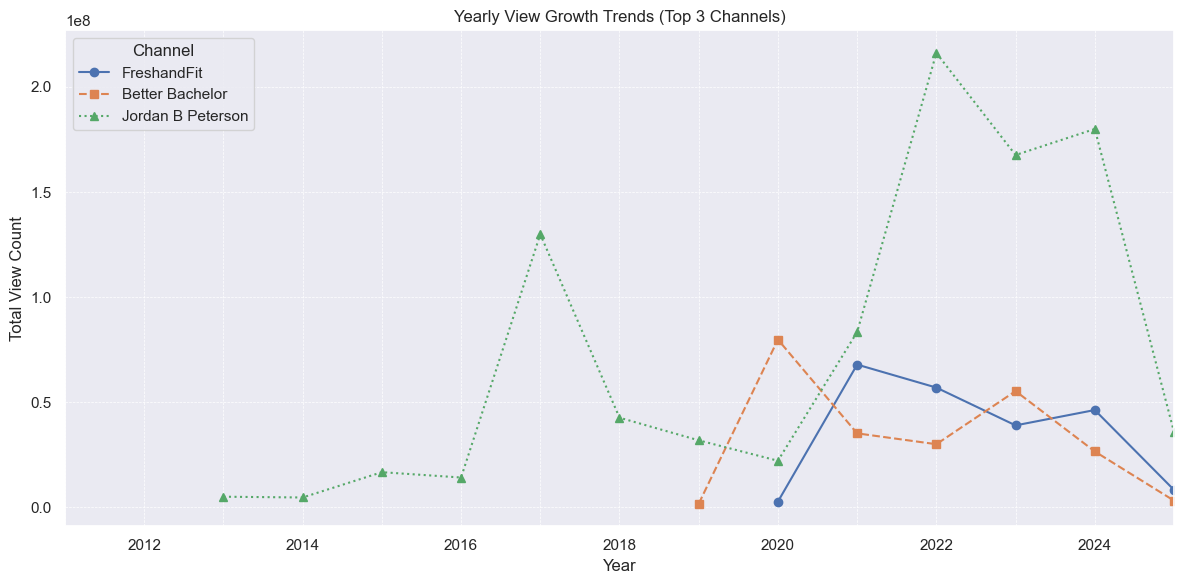

In [19]:
video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt'], errors='coerce')

video_df = video_df.dropna(subset=['publishedAt'])

yearly_growth = video_df.groupby(['channelTitle', pd.Grouper(key='publishedAt', freq='Y')])['viewCount'].sum().unstack()

non_zero_yearly_growth = yearly_growth[(yearly_growth.T != 0).any()]

non_zero_yearly_growth.T[['FreshandFit', 'Better Bachelor', 'Jordan B Peterson']].plot(
    figsize=(12, 6),
    style=['-o', '--s', ':^'],
    title="Yearly View Growth Trends (Top 3 Channels)"
)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("Year")
plt.ylabel("Total View Count")
plt.legend(title="Channel")
plt.tight_layout()
plt.show()

### Analysis of the Yearly View Growth Plot for Top 3 Channels

This data represents the yearly view growth trends for the top 3 YouTube channels: **FreshandFit**, **Better Bachelor**, and **Jordan B Peterson**. Each channel's growth trajectory shows unique patterns, reflecting their specific audience engagement and content strategies. Here's a detailed analysis:

####  **FreshandFit**
- **Peak Year (2021)**: 
  - FreshandFit experienced its highest growth in 2021, achieving **67.9 million views**. This suggests a breakout year, possibly due to viral content, increased visibility, or consistent engagement.
- **Lowest Year (2020)**:
  - In 2020, the channel had its lowest growth, with only **2.7 million views**, indicating it was still in its early stages of gaining traction.
- **Trend**:
  - After 2021, the channel saw a steady decline in yearly views, with **46.3 million views** in 2024 and **8.2 million views** in 2025. This may indicate a shift in audience interest or changes in content strategy.

#### **Better Bachelor**
- **Peak Year (2020)**:
  - Better Bachelor peaked in 2020 with **79.8 million views**, reflecting significant audience engagement during this year.
- **Lowest Year (2019)**:
  - The channel's lowest growth year was 2019, with just **1.7 million views**, likely indicating a period of limited reach or content development.
- **Trend**:
  - After its peak in 2020, the channel experienced a decline but maintained a moderate level of growth, with **26.6 million views** in 2024 and **3.1 million views** in 2025. This gradual decline suggests a potential plateau in audience retention.

#### **Jordan B Peterson**
- **Peak Year (2022)**:
  - Jordan B Peterson had an extraordinary peak in 2022 with **216.2 million views**, likely driven by highly popular content or significant public appearances.
- **Lowest Year (2014)**:
  - The channel's lowest year was 2014, with just **4.6 million views**, reflecting its early stages or a period of limited content output.
- **Trend**:
  - The channel shows a sustained high level of growth after its peak, with **180 million views** in 2024 and **35.8 million views** in 2025. This indicates a strong and relatively consistent audience base.

### Visualizing the Plot
- **Overall Trends**:
  - The plot would show **Jordan B Peterson** as the dominant channel in terms of yearly views, with a sharp peak in 2022 and steady high performance.
  - **FreshandFit** and **Better Bachelor** show more moderate trends, with distinct peaks (2021 and 2020, respectively) followed by gradual declines.

- **Comparison**:
  - Jordan B Peterson's peak is significantly higher than those of the other two channels, highlighting its broader audience reach or impact during 2022.
  - Both FreshandFit and Better Bachelor show similar patterns of rapid growth followed by stabilization or decline, suggesting a potential challenge in maintaining long-term growth.

### Insights
 **FreshandFit and Better Bachelor**:
   - These channels may need to innovate in content or marketing strategies to sustain growth and regain momentum.

 **Jordan B Peterson**:
   - The consistently high view counts indicate a strong connection with the audience, but the decline post-2022 suggests the need to adapt to changing audience preferences.

 **Growth Peaks**:
   - The channels' peak years likely correlate with specific events, content types, or external factors that resonated strongly with viewers.

### Inspecting Yearly View Growth Data for Top 3 Channels

Raw data was printed to verify the yearly view growth trends for the top 3 channels (**FreshandFit**, **Better Bachelor**, and **Jordan B Peterson**). This ensures accurate identification of peak and low years, along with their corresponding view counts, for analysis and visualization.

In [25]:
top_3_channels = ['FreshandFit', 'Better Bachelor', 'Jordan B Peterson']

data_top_3 = non_zero_yearly_growth.loc[top_3_channels]

print("Yearly View Growth Data (Top 3 Channels):")
print(data_top_3)

for channel in top_3_channels:
    channel_data = data_top_3.loc[channel]
    
    peak_year = channel_data.idxmax() 
    peak_value = channel_data.max()    
    low_year = channel_data.idxmin()  
    low_value = channel_data.min()  

    print(f"\nChannel: {channel}")
    print(f"  Peak Year: {peak_year.year}, Views: {peak_value}")
    print(f"  Lowest Year: {low_year.year}, Views: {low_value}")

Yearly View Growth Data (Top 3 Channels):
publishedAt        2011-12-31  2012-12-31  2013-12-31  2014-12-31  2015-12-31  \
channelTitle                                                                    
FreshandFit               NaN         NaN         NaN         NaN         NaN   
Better Bachelor           NaN         NaN         NaN         NaN         NaN   
Jordan B Peterson         NaN         NaN   5049872.0   4679385.0  16717822.0   

publishedAt        2016-12-31   2017-12-31  2018-12-31  2019-12-31  \
channelTitle                                                         
FreshandFit               NaN          NaN         NaN         NaN   
Better Bachelor           NaN          NaN         NaN   1719291.0   
Jordan B Peterson  14183935.0  129913687.0  42645130.0  31868209.0   

publishedAt        2020-12-31  2021-12-31   2022-12-31   2023-12-31  \
channelTitle                                                          
FreshandFit         2719747.0  67909858.0   56961980.0   38

### Identifying Top Videos for Key Dates Based on Growth Insights

This code was created to analyze the **specific months** corresponding to key growth periods (highs and lows) identified in the previous plot. By filtering videos based on these key dates, we can pinpoint the most impactful content that contributed to peak growth or examine content trends during the lowest growth periods. This insight helps in understanding content strategies and audience engagement patterns for each channel.

In [31]:
key_months = {
    "FreshandFit": [(2021, 8), (2020, 1)], 
    "Better Bachelor": [(2020, 6), (2019, 1)],
    "Jordan B Peterson": [(2022, 7), (2014, 1)]
}
for channel, months in key_months.items():
    print(f"--- Top Videos for {channel} ---\n")
    for year, month in months:
        videos_in_month = video_df[
            (video_df['publishedAt'].dt.year == year) &
            (video_df['publishedAt'].dt.month == month) &
            (video_df['channelTitle'] == channel)
        ]

        top_videos = videos_in_month.sort_values(by='viewCount', ascending=False)
        month_name = datetime(year, month, 1).strftime('%B %Y')
        print(f"Key Date: {month_name}")
        if not top_videos.empty:
            print("Top Video Titles:")
            for title in top_videos['title']:
                print(f"  - {title}")
        else:
            print("No videos found.")
        print("\n")


--- Top Videos for FreshandFit ---

Key Date: August 2021
Top Video Titles:
  - 3 Guests DEBATED If Women Are TRUSTWORTHY During Marriage!
  - Do Modern Women REALLY Know What MEN WANT? w/ 9 GIRLS
  - @FreshFitMiami Exposed? Debunking ALL false rumors w/ the TRUTH (Recorded phone calls, texts, video)
  - HEATED DEBATE: WHAT DO MEN AND WOMEN REALLY WANT w/9 girls
  - Can Men ACTUALLY be Faithful?
  - 2 Girls Disrespected the Podcast, and THIS happened FT. @MegaMcQueen
  - Are Modern Women Worth Marriage? w/ @YoungDonAnimations
  - KICKING OUT TEKASHI 69's GIRL Ft. @ZubyMusic @RolloTomassi
  - WHAT is LOYALTY Between Men&Women? FT. @MegaMcQueen
  - From a Sad & Single to Happy, Married & Feminine ft.@RebeccaBarrett & 4 Girls
  - CRAZY INTRUDER BREAK-IN EXPLAINED
  - KICKING OUT a Girl on "ZAZA" w/@RolloTomassi @StirlingCooper​
  - Are Modern Women Unrealistic With Standards? w/ 6 Girls
  - Do Girls Ever SABOTAGE Eachother?! w/6 Girls @DaquanWiltshire1
  - What REALLY Goes on During Girl’

### Analysis of Top Video Titles for Key Dates

#### **FreshandFit**
- **Key Date: August 2021 (Peak Year)**:
  - The top videos for FreshandFit during this period center around **debates on relationships, gender dynamics, and societal expectations**. Titles like *"Do Modern Women REALLY Know What MEN WANT?"* and *"Are Modern Women Worth Marriage?"* reflect the channel's focus on addressing controversial and trending topics, which likely contributed to its rapid growth in views during this time.
  - The variety of guests and topics, including discussions with influencers and reactions to cultural trends like OnlyFans content bans, likely attracted a diverse audience and fostered engagement.
- **Key Date: January 2020 (Low Year)**:
  - No videos were found for this period, indicating either a lack of activity or minimal traction during the early stages of the channel’s development.


#### **Better Bachelor**
- **Key Date: June 2020 (Peak Year)**:
  - The channel's top videos during this period revolve around **critiques of modern dating culture, societal expectations, and relationships**. Themes like women’s unrealistic standards (*"58 year old says no quality men want her"*) and the struggles of modern relationships (*"You're just a backup plan until she finds Mr. Wonderful"*) were recurring.
  - This focus on addressing men's perspectives on dating and societal issues likely struck a chord with the channel's target audience, driving its peak growth.
- **Key Date: January 2019 (Low Year)**:
  - No videos were found for this period, suggesting the channel was either in its infancy or had limited engagement at the time.

#### **Jordan B Peterson**
- **Key Date: July 2022 (Peak Year)**:
  - During its peak year, the channel's top videos featured **philosophical and societal commentary**, including analyses of political, cultural, and psychological topics. Titles like *"The Current Crisis of Masculinity"* and *"Why Should You Go to Church?"* reflect the channel's focus on deep intellectual discussions.
  - The diverse range of topics, including high-profile issues like the Russia-Ukraine war (*"My Thoughts on the Russia-Ukraine War"*) and critiques of societal norms (*"Why Twitter Is Insane"*), likely resonated with a broad audience, leading to significant growth.
- **Key Date: January 2014 (Low Year)**:
  - The videos during this period primarily consisted of **academic lectures on personality psychology**. Titles like *"2014 Personality Lecture 01: Introduction and Overview"* suggest that the channel initially served a more niche audience interested in academic content, which explains its limited growth during this time.

### Insight
The analysis of top video titles during key periods highlights the content strategies that contributed to each channel's growth. 

**FreshandFit** and **Better Bachelor** leveraged **controversial and culturally relevant topics**, appealing to audiences interested in debates around relationships and societal dynamics.
**Jordan B Peterson** transitioned from a niche academic focus in 2014 to delivering **wide-ranging intellectual commentary** in 2022, aligning with a broader audience and achieving peak growth.

---
## top 15 words

/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


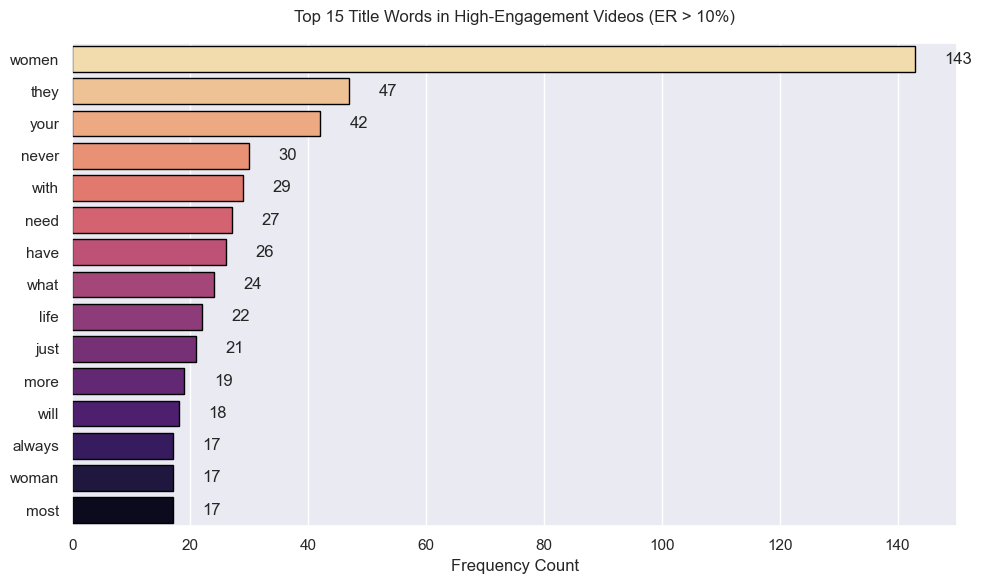

In [41]:
# 1. Clean and extract words (fixed version)
all_words = []
for title in video_df[video_df['engagement_rate'] > 0.1]['title']:
    # Remove punctuation and split
    words = re.findall(r'\b[a-z]+\b', title.lower())  # Cleans better than str.replace
    all_words.extend(words)

# 2. Count and filter
word_counts = Counter(all_words)
stopwords = set(['the', 'and', 'to', 'of', 'a', 'in', 'is', 'it', 'that', 'this'])
top_words = {word: count for word, count in word_counts.items() 
             if word not in stopwords and len(word) > 3}  # Filter short words

# 3. Get top 15
top_15 = Counter(top_words).most_common(15)

# 4. Plot with improved formatting
plt.figure(figsize=(10, 6))
sns.barplot(
    x=[count for word, count in top_15],
    y=[word for word, count in top_15],
    palette='magma_r',
    edgecolor='black'
)

# 5. Professional annotations
plt.title("Top 15 Title Words in High-Engagement Videos (ER > 10%)", pad=15)
plt.xlabel("Frequency Count")
plt.ylabel("")
for i, (word, count) in enumerate(top_15):
    plt.text(count + 5, i, f"{count}", va='center')

plt.tight_layout()
plt.show()

---
## Comment sent

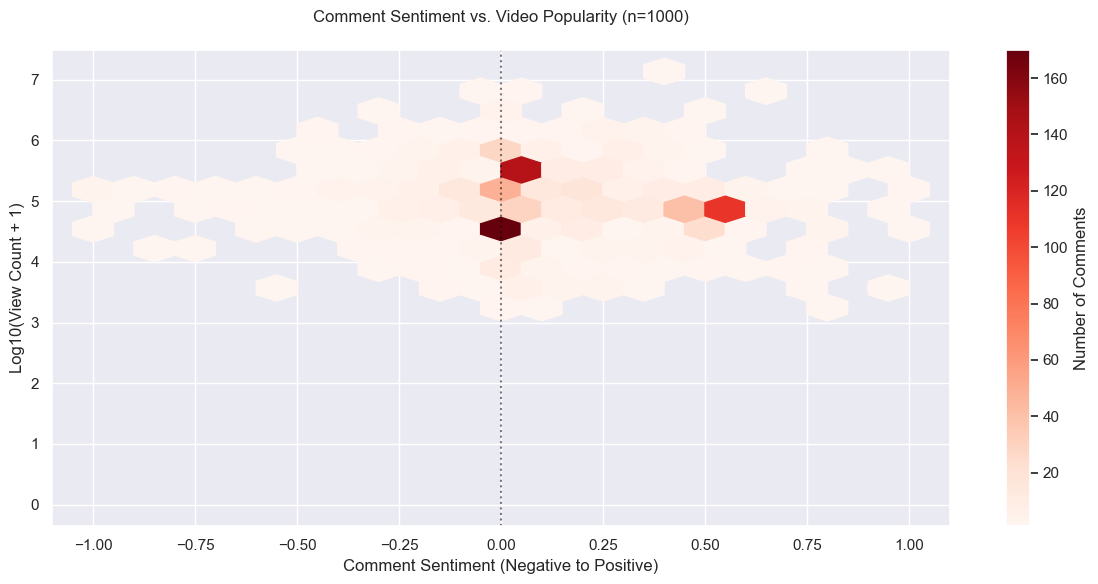

In [43]:
# 1. Sample and merge data (ensure 'video_id' exists in both DataFrames)
comment_sample = comments_df.sample(1000, random_state=42).copy()
merged_data = comment_sample.merge(
    video_df[['video_id', 'viewCount']],  # Make sure video_df has 'video_id'
    on='video_id',
    how='left'
)

# 2. Calculate sentiment ON THE MERGED DATA
merged_data['sentiment'] = merged_data['comment'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else np.nan
)

# 3. Filter valid data
plot_data = merged_data[
    (merged_data['viewCount'] > 0) & 
    (merged_data['sentiment'].notna())
].copy()

# 4. Create visualization
if len(plot_data) > 0:
    plt.figure(figsize=(12, 6))
    hexbin = plt.hexbin(
        x=plot_data['sentiment'],
        y=np.log10(plot_data['viewCount'] + 1),  # +1 to avoid log(0)
        gridsize=20,
        cmap='Reds',
        mincnt=1,
        extent=[-1, 1, 0, np.log10(plot_data['viewCount'].max() + 1)]
    )
    
    # Formatting
    plt.title(f"Comment Sentiment vs. Video Popularity (n={len(plot_data)})", pad=20)
    plt.xlabel("Comment Sentiment (Negative to Positive)")
    plt.ylabel("Log10(View Count + 1)")
    cb = plt.colorbar(hexbin, label='Number of Comments')
    plt.axvline(0, color='black', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("Warning: No valid data points after filtering!")
    print("Check if: 1) Comments merged correctly, 2) View counts exist, 3) Sentiment was calculated")

---
## feature im3portance 

Training R²: 0.912
Test R²: 0.534


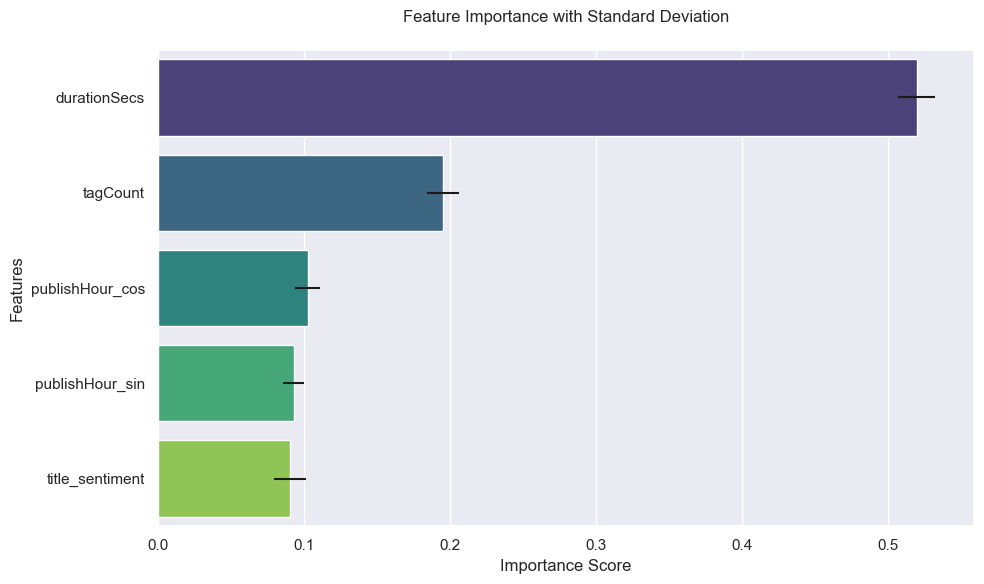


Feature Importances:
           feature  importance       std
0     durationSecs    0.519515  0.012627
2         tagCount    0.195147  0.011117
4  publishHour_cos    0.102302  0.008857
3  publishHour_sin    0.092811  0.007374
1  title_sentiment    0.090225  0.011125


In [46]:
video_df['publishHour_sin'] = np.sin(2 * np.pi * video_df['publishHour']/24)
video_df['publishHour_cos'] = np.cos(2 * np.pi * video_df['publishHour']/24)

# 2. Feature engineering (verify columns exist)
required_features = ['durationSecs', 'title_sentiment', 'tagCount', 
                    'publishHour_sin', 'publishHour_cos']
assert all(feat in video_df.columns for feat in required_features), \
       f"Missing columns: {set(required_features) - set(video_df.columns)}"

X = video_df[required_features]
y = video_df['engagement_rate']

# 3. Handle missing values and align X and y
# Create a mask of rows where neither X nor y has NA values
mask = X.notna().all(axis=1) & y.notna()

# Apply the mask to both X and y
X_clean = X[mask]
y_clean = y[mask]

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, 
    y_clean, 
    test_size=0.2, 
    random_state=42
)

# 5. Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. Evaluate model performance
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Training R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

# 7. Feature importance analysis
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_,
    'std': np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
}).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importances,
    x='importance',
    y='feature',
    xerr=importances['std'],
    palette='viridis'
)
plt.title("Feature Importance with Standard Deviation", pad=20)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Optional: Show the feature importance dataframe
print("\nFeature Importances:")
print(importances)

---
# Comments

In [20]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comment'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

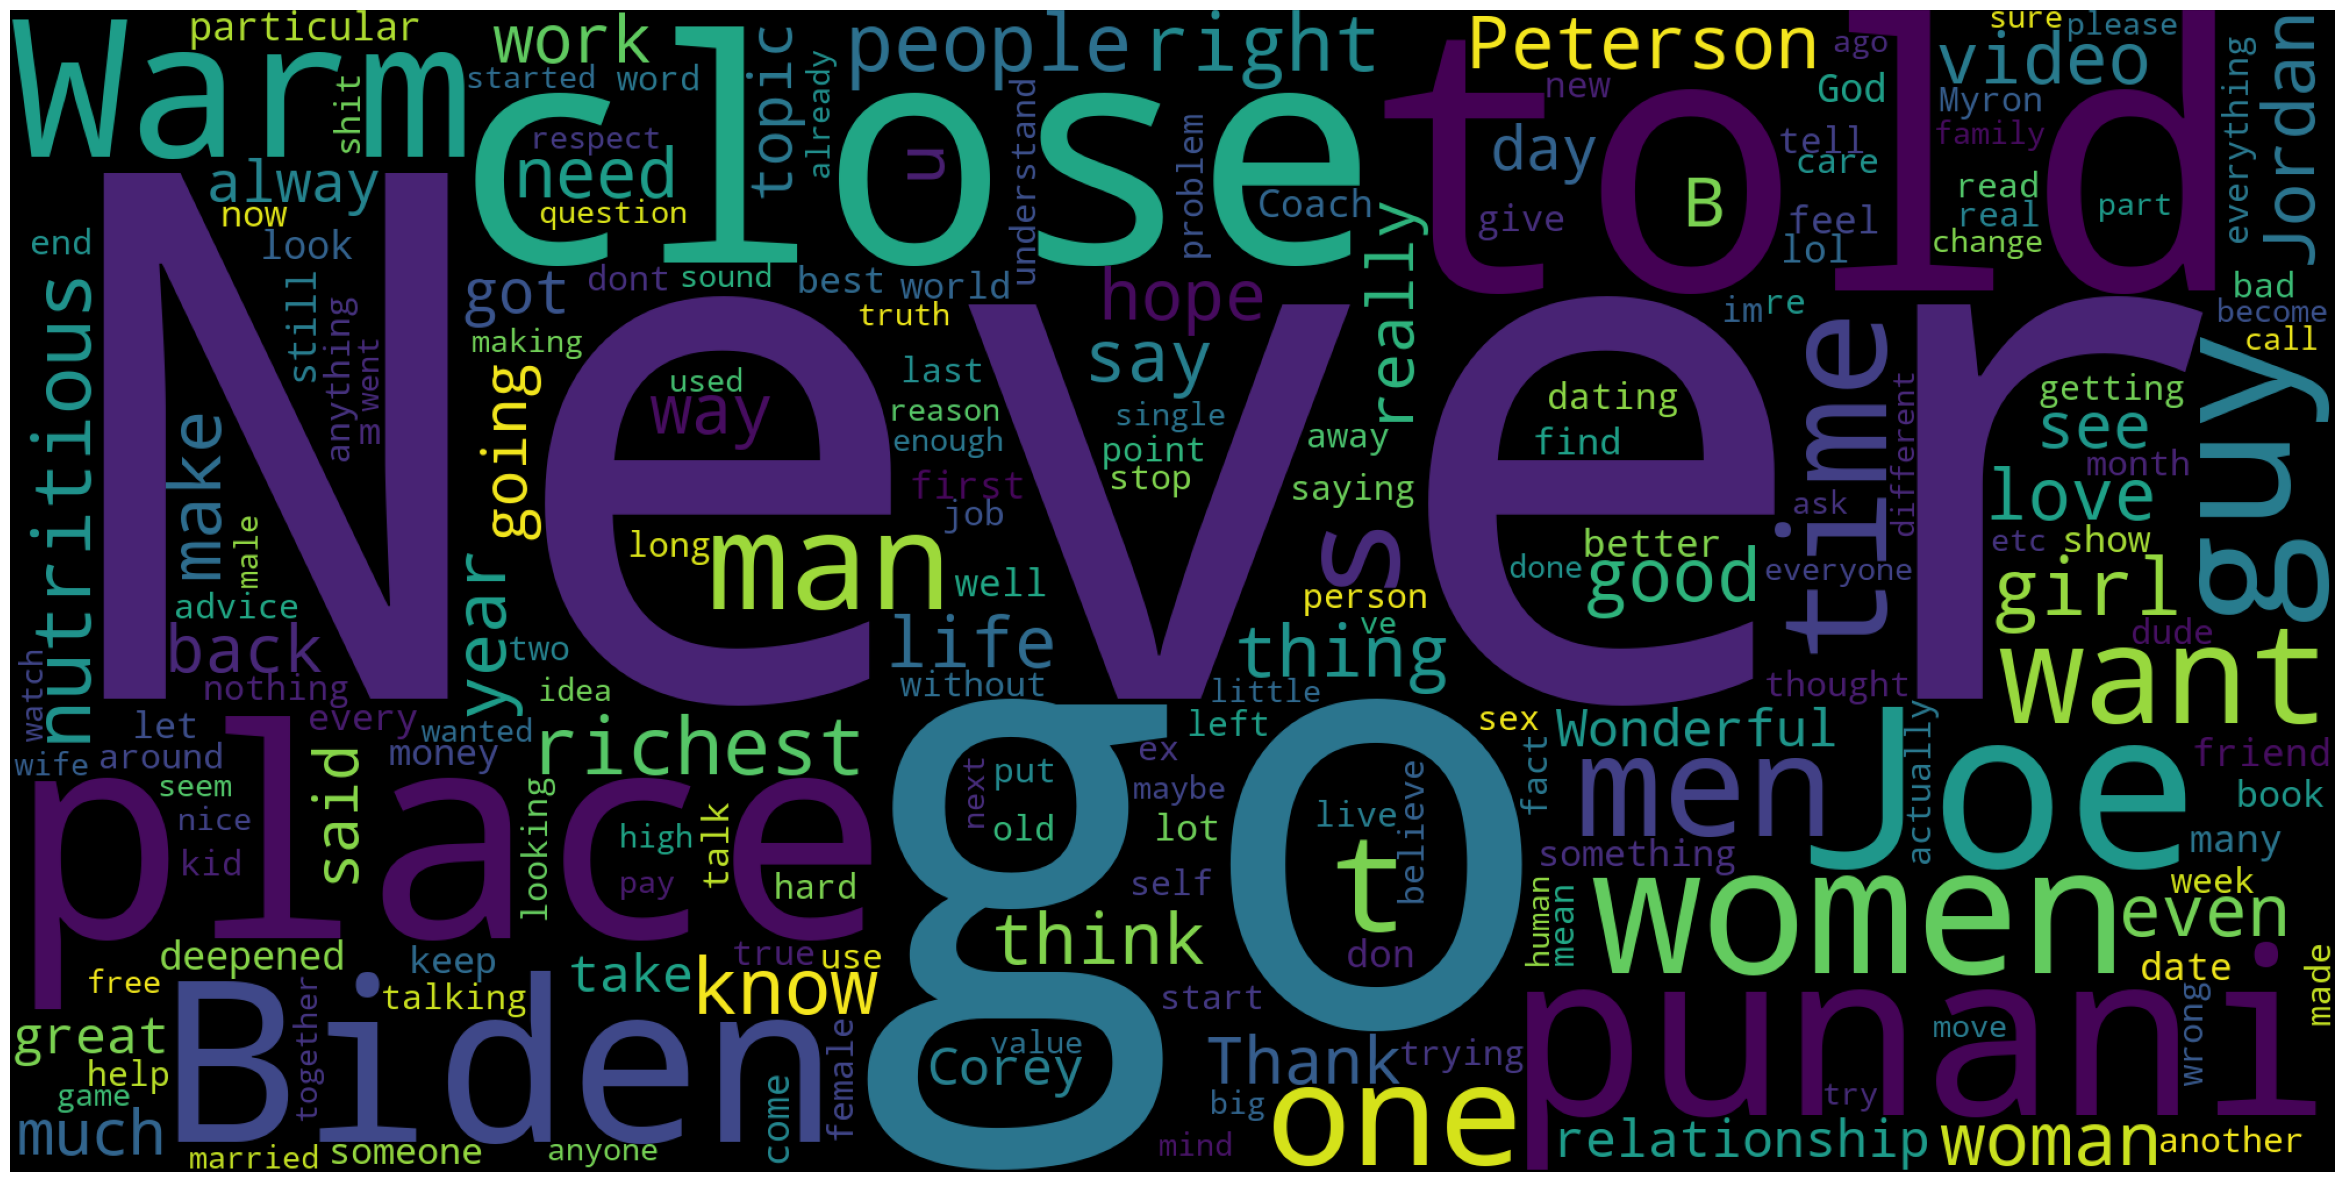

In [21]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)